# 6차 전직 관련

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import unicodedata
from statsmodels.stats.proportion import proportions_ztest
import scipy.stats as stats
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
import matplotlib.lines as mlines

In [ ]:
# hexamatrix_stat 데이터 모두 불러오기

# 상위 폴더 경로
root_dir = "/content/drive/MyDrive/data/hexamatrix_stat" # 수정

# 하위 모든 CSV 탐색
all_csv_files = glob.glob(os.path.join(root_dir, "*/*.csv"))

df_list = []
for file in all_csv_files:
    df = pd.read_csv(file)
    folder_name = os.path.basename(os.path.dirname(file))
    job_file = os.path.basename(file).replace("_hexamatrix_stat.csv", "") # 수정
    df["job_group"] = folder_name
    df_list.append(df)

# 전체 통합
hexamatrix_stat_df = pd.concat(df_list, ignore_index=True) # 수정

In [ ]:
# hexamatrix 데이터 모두 불러오기

# 상위 폴더 경로
root_dir = "/content/drive/MyDrive/data/hexamatrix" # 수정

# 하위 모든 CSV 탐색
all_csv_files = glob.glob(os.path.join(root_dir, "*/*.csv"))

df_list = []
for file in all_csv_files:
    df = pd.read_csv(file)
    folder_name = os.path.basename(os.path.dirname(file))
    job_file = os.path.basename(file).replace("_hexamatrix.csv", "") # 수정
    df["job_group"] = folder_name
    df_list.append(df)

# 전체 통합
hexamatrix_df = pd.concat(df_list, ignore_index=True) # 수정

## 가설 1
----
헥사 스탯의 경우, 메인 스탯이 7강 이상인 유저보다 7강 미만인 유저들이 더 많을 것이다.

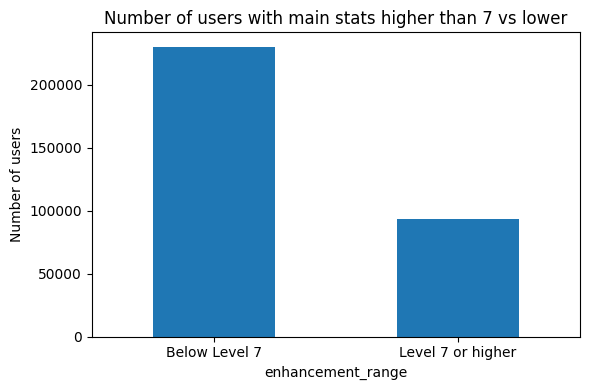

In [ ]:
# 7강 기준 나누기
hexamatrix_stat_df["main_stat_level"] = pd.to_numeric(hexamatrix_stat_df["main_stat_level"], errors="coerce")
hexamatrix_stat_df["enhancement_range"] = hexamatrix_stat_df["main_stat_level"].apply(lambda x: "Level 7 or higher" if x >= 7 else "Below Level 7")

# 분포 시각화
plt.figure(figsize=(6, 4))
hexamatrix_stat_df["enhancement_range"].value_counts().plot(kind="bar")
plt.title("Number of users with main stats higher than 7 vs lower")
plt.ylabel("Number of users")
plt.xticks(rotation=0)
# plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

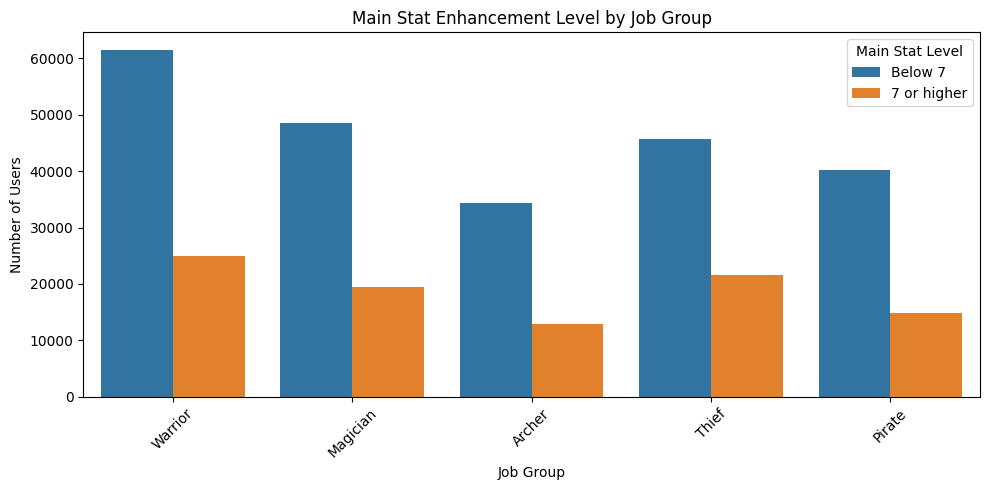

In [ ]:
# 직업군별 분포 확인(인원 수)

# 한글 문자열에 유니코드 정규화 적용
hexamatrix_stat_df["job_group"] = hexamatrix_stat_df["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))

# 직업군 이름 매핑하기(한글 -> 영어)
group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
hexamatrix_stat_df["job_group_eng"] = hexamatrix_stat_df["job_group"].map(group_map)

# main_stat_level 숫자화 + 범주화
hexamatrix_stat_df["main_stat_level"] = pd.to_numeric(hexamatrix_stat_df["main_stat_level"], errors="coerce")
hexamatrix_stat_df["main_stat_range"] = hexamatrix_stat_df["main_stat_level"].apply(lambda x: "7 or higher" if x >= 7 else "Below 7")

# 정렬 순서 지정
job_order = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]

hexamatrix_stat_df["job_group_eng"] = pd.Categorical(
    hexamatrix_stat_df["job_group_eng"],
    categories=job_order,
    ordered=True
)

# 시각화
plt.figure(figsize=(10, 5))
sns.countplot(data=hexamatrix_stat_df, x="job_group_eng", hue="main_stat_range")

plt.title("Main Stat Enhancement Level by Job Group")
plt.xlabel("Job Group")
plt.ylabel("Number of Users")
plt.xticks(rotation=45)
plt.legend(title="Main Stat Level")
plt.tight_layout()
plt.show()

<ipython-input-36-e1b92fa8ae57>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["job_group_eng", "main_stat_range"])


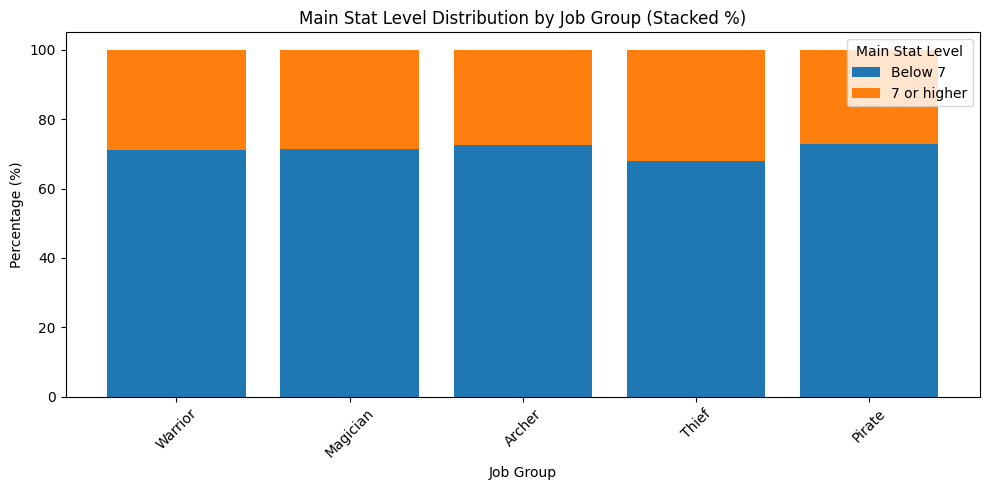

In [ ]:
# 직업군별 분포 확인(비율)

# 비율 테이블 만들기
count_df = (
    hexamatrix_stat_df
    .groupby(["job_group_eng", "main_stat_range"])
    .size()
    .unstack(fill_value=0)
)

# 비율 계산
percent_df = count_df.div(count_df.sum(axis=1), axis=0) * 100

# 정렬 순서 지정
job_order = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
percent_df = percent_df.reindex(job_order)

# 컬럼 순서 고정: Below 7을 위로, 7 or higher를 아래로
percent_df = percent_df[["Below 7", "7 or higher"]]

# 색상 매핑
color_map = {
    "Below 7": "#1f77b4",     # 파란색
    "7 or higher": "#ff7f0e"  # 주황색
}


# 색상 매핑 설정
color_map = {
    "Below 7": "#1f77b4",     # 파란색
    "7 or higher": "#ff7f0e"  # 주황색
}

# 시각화
plt.figure(figsize=(10, 5))

bottom = None
for label in percent_df.columns:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label=label,
        color=color_map.get(label, "#cccccc")  # 혹시나 label이 누락됐을 경우 기본 회색
    )
    if bottom is None:
        bottom = percent_df[label]
    else:
        bottom += percent_df[label]

plt.title("Main Stat Level Distribution by Job Group (Stacked %)")
plt.ylabel("Percentage (%)")
plt.xlabel("Job Group")
plt.xticks(rotation=45)
plt.legend(title="Main Stat Level")
plt.tight_layout()
plt.show()

시각화 결과: 헥사 스탯의 경우 7강 미만으로 강화한 유저들이 더 많다. **(기존 가설 = TRUE)**
- 또한 모든 직업군에서 같은 추세를 보이고 있다.

### 추론 통계

In [ ]:
# 단일 집단의 비율 검정(z-test)

# 가상의 값 예시
count_7plus = hexamatrix_stat_df[hexamatrix_stat_df["main_stat_level"] >= 7].shape[0]
count_total = hexamatrix_stat_df.shape[0]
count_below7 = count_total - count_7plus

# 검정: 7강 이상 비율이 0.5보다 낮은지 (단측 검정)
stat, pval = proportions_ztest(count_7plus, count_total, value=0.5, alternative='smaller')

print(f"z-statistic: {stat:.3f}, p-value: {pval:.4f}")

z-statistic: -264.847, p-value: 0.0000


- 귀무가설(H₀): 7강 이상인 유저 비율 = 7강 미만인 유저 비율
- 대립가설(H₁): 7강 미만인 유저 비율 > 7강 이상인 유저 비율
  - **p-value < α(0.05)로, 대립가설을 채택하여 메인 스탯을 7강 미만으로 강화한 유저 비율이 유의미하게 더 높게 나타났다고 할 수 있다.**

In [ ]:
# 직업군별: 카이제곱 독립성 검정

# 교차표 만들기
hexamatrix_stat_df["hex_7plus"] = hexamatrix_stat_df["main_stat_level"] >= 7
crosstab = pd.crosstab(hexamatrix_stat_df["job_group_eng"], hexamatrix_stat_df["hex_7plus"])

# 카이제곱 검정
chi2, pval, dof, expected = stats.chi2_contingency(crosstab)

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

# 교차표 재사용
crosstab = pd.crosstab(hexamatrix_stat_df["job_group_eng"], hexamatrix_stat_df["main_stat_level"] >= 7)

# 카이제곱 통계량, 자유도, 기대값
chi2, pval, dof, expected = stats.chi2_contingency(crosstab)

# 크래머의 V 계산
n = crosstab.sum().sum()  # 전체 샘플 수
min_dim = min(crosstab.shape) - 1  # 최소 카테고리 수 - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Cramér's V: {cramers_v:.4f}")

Chi-square: 468.558, p-value: 0.0000
Cramér's V: 0.0380


- 귀무가설(H₀): 직업군과 헥사 강화 정도는 독립적이다. (직업군에 따라 7강 이상 비율이 차이나지 않음)
- 대립가설(H₁): 직업군에 따라 7강 이상 비율이 다르다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 강화 분포의 차이는 통계적으로 유의미한 수준으로 나타났다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.0380으로 관계의 강도는 매우 약한 수준**이었고, 이는 실질적으로 직업군이 헥사 메인스탯 강화 수준에 미치는 영향은 미미하다고 해석할 수 있다. 즉, **강화 수준은 대부분의 직업군에서 유사한 방향으로 나타나며, 특정 직업군의 특성에 의해 큰 차이를 보이지는 않는다.**

### **최종 정리**
----
헥사 메인스탯 강화에 있어 유저들은 **7강 미만 구간에 가장 많이 분포**되어 있으며,
이는 전체 유저들 사이에서 **일정 수준 이상의 강화까지 도달하지 못하는 경향**이 유의미하게 존재함을 보여준다.

직업군별로 살펴보면 통계적으로 분포 차이는 존재했지만, **관련성의 강도는 낮아**,
실질적으로는 **모든 직업군에서 유사한 강화 추세가 나타나는 공통된 패턴**으로 해석할 수 있다.

## 가설 2
----
마스터리 코어와 강화 코어의 경우, 1~10강 사이로 강화한 유저들이 더 많을 것이다.

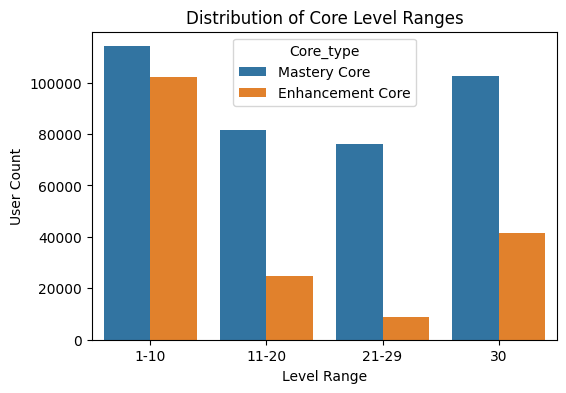

In [ ]:
# 마스터리 코어와 강화 코어만 필터링
filtered_df = hexamatrix_df[hexamatrix_df['hexa_core_type'].isin(['마스터리 코어', '강화 코어'])].copy()

# 한글을 영어로 매핑
type_map = {
    '마스터리 코어': 'Mastery Core',
    '강화 코어': 'Enhancement Core'
}
filtered_df['Core_type'] = filtered_df['hexa_core_type'].map(type_map)

# 강화 레벨 범위 구분
def level_range(level):
    if level <= 10:
        return '1-10'
    elif level <= 20:
        return '11-20'
    elif level <= 29:
        return '21-29'
    else:
        return '30'

filtered_df['level_range'] = filtered_df['hexa_core_level'].apply(level_range)

# 원하는 순서대로 category 설정
ordered_levels = ['1-10', '11-20', '21-29', '30']
filtered_df['level_range'] = pd.Categorical(
    filtered_df['level_range'],
    categories=ordered_levels,
    ordered=True
)

# 범위별 분포 시각화
import seaborn as sns
plt.figure(figsize=(6, 4))
sns.countplot(data=filtered_df, x='level_range', hue='Core_type')
plt.title("Distribution of Core Level Ranges")
plt.xlabel("Level Range")
plt.ylabel("User Count")
plt.show()

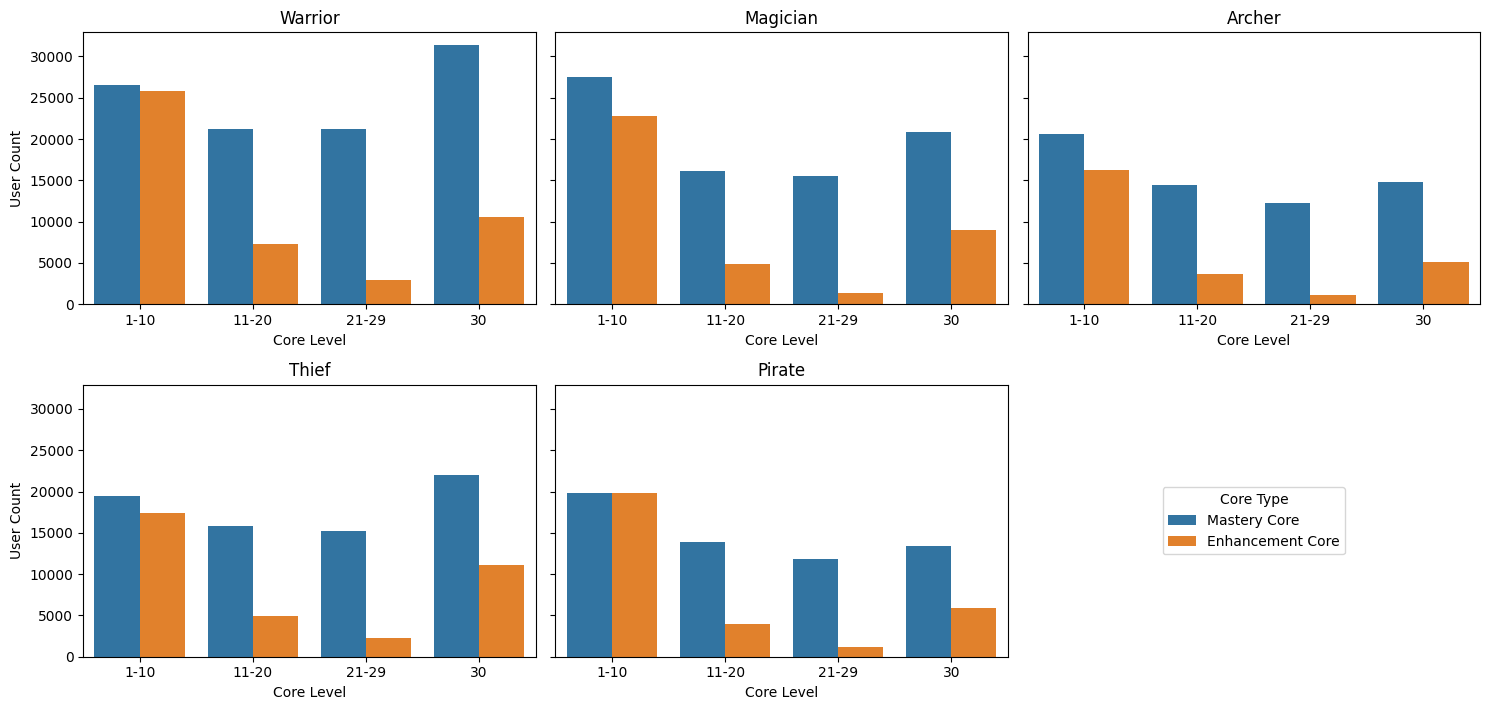

In [ ]:
# 직업군별 추세 확인

# 유니코드 정규화
hexamatrix_df["job_group"] = hexamatrix_df["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))

# 한글 -> 영어 매핑
group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
hexamatrix_df["job_group_eng"] = hexamatrix_df["job_group"].map(group_map)

# 직업군 리스트 (순서 고정)
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]

# 서브플롯 설정
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=True)
axes = axes.flatten()

# 범례 저장용
handles = None
labels = None

# 직업군별 그래프
for idx, group in enumerate(job_groups):
    ax = axes[idx]
    subset = filtered_df[filtered_df['job_group_eng'] == group]
    plot = sns.countplot(data=subset, x='level_range', ax=ax, hue='Core_type')

    ax.set_title(group)
    ax.set_xlabel("Core Level")
    ax.set_ylabel("User Count")
    ax.tick_params(axis='x', rotation=0)

    if handles is None and labels is None:
        handles, labels = ax.get_legend_handles_labels()
    ax.get_legend().remove()

# 빈 subplot 비우기 + 범례로 활용
for j in range(len(job_groups), len(axes)):
    legend_ax = axes[j]
    legend_ax.axis("off")
    legend_ax.legend(handles, labels, title="Core Type", loc="center")

# 레이아웃 조정 (아래 공간 확보)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

시각화 결과:
- 마스터리 코어의 경우, 1-10강 사이로 강화한 유저들이 가장 많다. **(기존 가설 = TRUE)**
- 강화 코어의 경우, 1~10강 사이로 강화한 유저들이 가장 많다. **(기존 가설 = TRUE)**
  - 그러나 직업군별로 살펴봤을 때, 전사 직업군과 도적 직업군은 마스터리 코어를 30강까지 강화한 유저들의 수가 가장 많았다.
  - 마스터리 코어의 중요도 OR 고스펙 유저

### 추론 통계

In [ ]:
# 전체 유저 기준(마스터리 코어): 카이제곱 적합도 검정

# 마스터리 코어만 필터링
mastery_df = filtered_df[filtered_df['Core_type'] == 'Mastery Core']

# 구간별 분포
counts = mastery_df['level_range'].value_counts().reindex(ordered_levels, fill_value=0)
observed = counts.values

# 균등 분포 가정
expected = [sum(observed) / 4] * 4

# 카이제곱 적합도 검정
chi2, pval = chisquare(f_obs=observed, f_exp=expected)

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

Chi-square: 10140.765, p-value: 0.0000


- 귀무가설(H₀): 마스터리 코어의 강화 구간 분포는 균등하다. (각 구간별 유저 수가 동일한 비율로 분포)
- 대립가설(H₁): 마스터리 코어의 강화 구간 분포는 균등하지 않다. (특정 구간에 쏠림이 있음)
  - **p-value < α(0.05)로, 대립가설을 채택하여 마스터리 코어는 균등하지 않은 분포를 가지며, 특히 1~10강 구간에 유저가 집중되어 있다는 쏠림 현상이 통계적으로 유의미하다고 할 수 있다.**

In [ ]:
# 전체 유저 기준(강화 코어): 카이제곱 적합도 검정

# 강화 코어만 필터링
enhancement_df = filtered_df[filtered_df['Core_type'] == 'Enhancement Core']

# 구간별 분포 수
counts = enhancement_df['level_range'].value_counts().reindex(ordered_levels, fill_value=0)
observed = counts.values

# 균등 분포 가정
expected = [sum(observed) / 4] * 4

# 적합도 검정
chi2, pval = chisquare(f_obs=observed, f_exp=expected)

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

Chi-square: 113116.968, p-value: 0.0000


- 귀무가설(H₀): 강화 코어의 강화 구간 분포는 균등하다.
- 대립가설(H₁): 강화 코어의 강화 구간 분포는 균등하지 않다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 강화 코어 역시 균등하지 않은 분포를 가지며, 특히 1~10강 구간에 유저가 집중되어 있다는 쏠림 현상이 통계적으로 유의미하다고 할 수 있다.**

In [ ]:
# 직업군별 차이: 카이제곱 독립성 검정

# 직업군 vs 강화 구간 교차표
crosstab = pd.crosstab(filtered_df["job_group_eng"], filtered_df["level_range"])

# 독립성 검정
chi2, pval, dof, expected = stats.chi2_contingency(crosstab)

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Cramér's V: {cramers_v:.4f}")

Chi-square: 5118.066, p-value: 0.0000
Cramér's V: 0.0556


- 귀무가설(H₀): 직업군과 코어 강화 구간은 서로 독립적이다. (직업군이 무엇이든 강화 구간 분포는 동일)
- 대립가설(H₁): 직업군과 코어 강화 구간은 독립적이지 않다 (직업군에 따라 강화 경향에 차이가 있음)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 강화 구간 분포는 통계적으로 유의미하게 차이가 있다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.0556**으로, 그 **관계의 강도는 매우 약한 수준**이다.
이는 **직업군이 강화 구간 분포에 영향을 주긴 하지만,
실질적인 차이는 크지 않으며, 강화 패턴은 전반적으로 유사한 경향을 보인다**는 것을 의미한다.

### **최종 정리**
----
마스터리 코어와 강화 코어는 전반적으로 **1~10강 구간에 유저들이 집중되어 있는 비균등한 분포 특성**을 보였으며,
이는 유저들이 마스터리 코어와 강화 코어를 **가성비 중심으로 운용하는 경향**이 강하다는 점을 보여준다.

직업군에 따라 미묘한 차이는 존재했지만, 관계의 강도는 낮은 수준(Cramér’s V = 0.0556)에 머물렀으며,
결과적으로 **강화 구간 선택은 직업군보다는 개인의 성장 전략이나 자원 상황에 더 크게 영향을 받는 것으로 해석**할 수 있다.

# 아이템 관련: 스타포스

In [ ]:
# item 데이터 모두 불러오기

# 상위 폴더 경로
root_dir = "/content/drive/MyDrive/data/item" # 수정

# 하위 모든 CSV 탐색
all_csv_files = glob.glob(os.path.join(root_dir, "*/*.csv"))

df_list = []
for file in all_csv_files:
    df = pd.read_csv(file)
    folder_name = os.path.basename(os.path.dirname(file))
    job_file = os.path.basename(file).replace("_equipment.csv", "") # 수정
    df["job_group"] = folder_name
    df_list.append(df)

# 전체 통합
item_df = pd.concat(df_list, ignore_index=True) # 수정

In [ ]:
# 메이플의 장비 프리셋은 총 3개 -> 가장 추가옵션이 높은 프리셋 하나만 사용하여 분석

# 직업별 주스탯 맵핑
main_stat_map = {
    "STR": ["히어로", "아델", "소울마스터", "아란", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df["main_stat_type"] = item_df.apply(get_main_stat, axis=1)

# 추옵 계산 함수
def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None:
        return 0
    allstat = row["all_stat_add"] * 10
    if stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    elif stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"] + allstat
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df["bonus_stat_total"] = item_df.apply(calculate_bonus_stat, axis=1)

# 유저별 + 부위별 가장 높은 bonus_stat_total을 가진 프리셋만 추출
item_df_best = (
    item_df.loc[item_df.groupby(["nickname", "equipment_part"])["bonus_stat_total"].idxmax()]
    .reset_index(drop=True)
)

In [ ]:
list(item_df_best.columns)

['nickname',
 'world',
 'level',
 'job',
 'subclass',
 'preset_number',
 'equipment_part',
 'equipment_slot',
 'item_name',
 'str_total',
 'dex_total',
 'int_total',
 'luk_total',
 'max_hp_total',
 'max_mp_total',
 'attack_power_total',
 'magic_power_total',
 'armor_total',
 'speed_total',
 'jump_total',
 'boss_damage_total',
 'ignore_monster_armor_total',
 'all_stat_total',
 'damage_total',
 'equipment_level_decrease_total',
 'max_hp_rate_total',
 'max_mp_rate_total',
 'str_base',
 'dex_base',
 'int_base',
 'luk_base',
 'max_hp_base',
 'max_mp_base',
 'attack_power_base',
 'magic_power_base',
 'armor_base',
 'speed_base',
 'jump_base',
 'boss_damage_base',
 'ignore_monster_armor_base',
 'all_stat_base',
 'max_hp_rate_base',
 'max_mp_rate_base',
 'base_equipment_level_base',
 'potential_option_grade',
 'additional_potential_option_grade',
 'potential_option_1',
 'potential_option_2',
 'potential_option_3',
 'additional_potential_option_1',
 'additional_potential_option_2',
 'additional

In [ ]:
item_df_best.info(max_cols=300)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 895034 entries, 0 to 895033
Data columns (total 114 columns):
 #    Column                             Non-Null Count   Dtype  
---   ------                             --------------   -----  
 0    nickname                           895034 non-null  object 
 1    world                              895034 non-null  object 
 2    level                              895034 non-null  int64  
 3    job                                895034 non-null  object 
 4    subclass                           895034 non-null  object 
 5    preset_number                      895034 non-null  int64  
 6    equipment_part                     895034 non-null  object 
 7    equipment_slot                     895034 non-null  object 
 8    item_name                          895034 non-null  object 
 9    str_total                          895034 non-null  int64  
 10   dex_total                          895034 non-null  int64  
 11   int_total               

## 가설 3
----
칠흑 아이템의 경우, 스타포스 22성 미만의 아이템을 사용하는 유저가 더 많을 것이다.

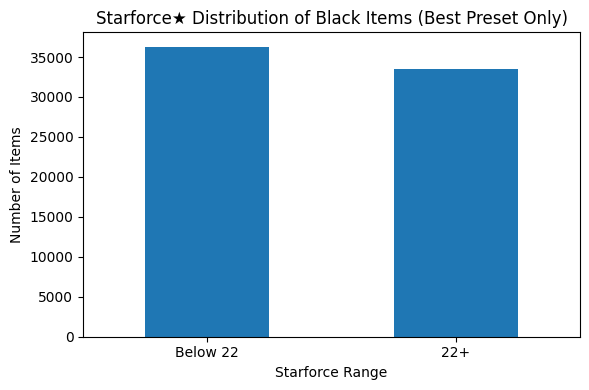

In [ ]:
# 칠흑 아이템 리스트
black_items = [
    "루즈 컨트롤 머신 마크", "마력이 깃든 안대", "블랙 하트", "컴플리트 언더컨트롤",
    "몽환의 벨트", "고통의 근원", "창세의 뱃지", "커맨더 포스 이어링",
    "거대한 공포", "저주받은 마도서", "미트라의 분노"
]

# 칠흑 아이템 필터링
black_eq_df = item_df_best[item_df_best["item_name"].isin(black_items)].copy()

# 스타포스 구간 분류
black_eq_df["starforce_group"] = black_eq_df["starforce"].apply(
    lambda x: "Below 22" if x < 22 else "22+"
)

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
black_eq_df["starforce_group"].value_counts().reindex(["Below 22", "22+"], fill_value=0).plot(kind="bar")

plt.title("Starforce★ Distribution of Black Items (Best Preset Only)")
plt.xlabel("Starforce Range")
plt.ylabel("Number of Items")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

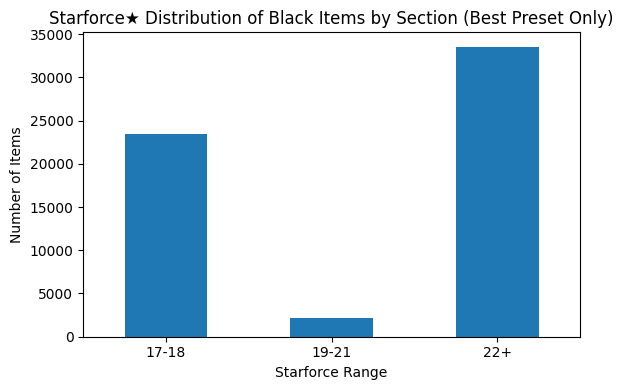

In [ ]:
# 스타포스 구간을 더 세분화하여 보기

# 칠흑 아이템 리스트
black_items = [
    "루즈 컨트롤 머신 마크", "마력이 깃든 안대", "블랙 하트", "컴플리트 언더컨트롤",
    "몽환의 벨트", "고통의 근원", "창세의 뱃지", "커맨더 포스 이어링",
    "거대한 공포", "저주받은 마도서", "미트라의 분노"
]

# 필터링: 사용 중인 최고 추옵 프리셋 기준
black_eq_df = item_df_best[item_df_best["item_name"].isin(black_items)].copy()

# 스타포스 구간 분류
def categorize_starforce(x):
    if x in [17, 18]:
        return "17-18"
    elif x in [19, 20, 21]:
        return "19-21"
    elif x >= 22:
        return "22+"
    else:
        return "Below 17"

black_eq_df["starforce_range"] = black_eq_df["starforce"].apply(categorize_starforce)

# 필요한 구간만 시각화
filtered = black_eq_df[black_eq_df["starforce_range"].isin(["17-18", "19-21", "22+"])]

# 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
filtered["starforce_range"].value_counts().reindex(["17-18", "19-21", "22+"], fill_value=0).plot(kind="bar")

plt.title("Starforce★ Distribution of Black Items by Section (Best Preset Only)")
plt.xlabel("Starforce Range")
plt.ylabel("Number of Items")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

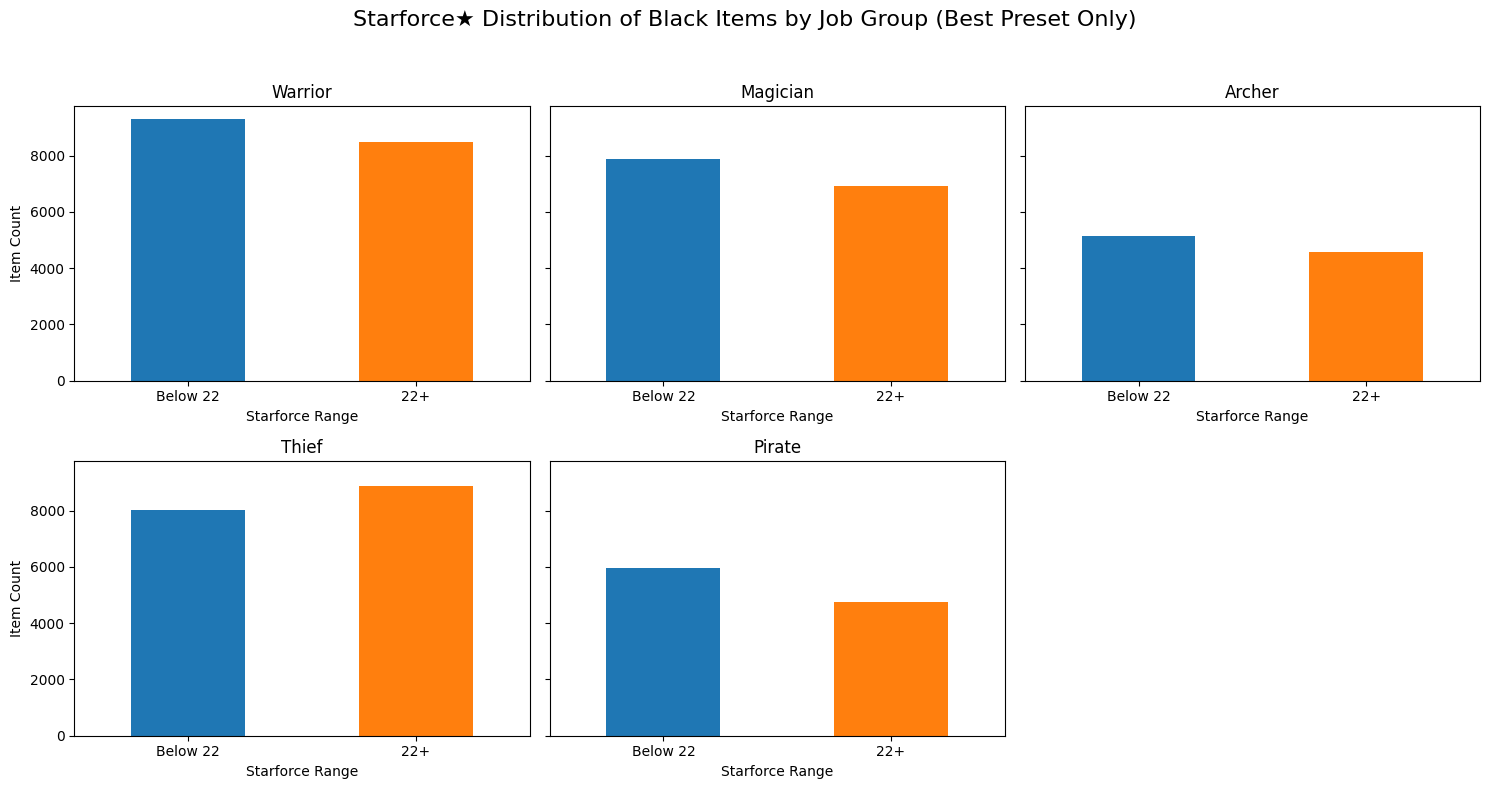

In [ ]:
# 직업군별로 살펴보기

# 유니코드 정규화 + 직업군 영문 매핑
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 칠흑 아이템 리스트
black_items = [
    "루즈 컨트롤 머신 마크", "마력이 깃든 안대", "블랙 하트", "컴플리트 언더컨트롤",
    "몽환의 벨트", "고통의 근원", "창세의 뱃지", "커맨더 포스 이어링",
    "거대한 공포", "저주받은 마도서", "미트라의 분노"
]

# 칠흑 아이템 필터링
black_eq_df = item_df_best[item_df_best["item_name"].isin(black_items)].copy()

# 스타포스 구간 구분
black_eq_df["starforce_group"] = black_eq_df["starforce"].apply(
    lambda x: "Below 22" if x < 22 else "22+"
)

# 직업군별 subplot 시각화
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for idx, group in enumerate(job_groups):
    ax = axes[idx]
    subset = black_eq_df[black_eq_df["job_group_eng"] == group]
    count_series = subset["starforce_group"].value_counts().reindex(["Below 22", "22+"], fill_value=0)
    count_series.plot(kind="bar", ax=ax, color=["#1f77b4", "#ff7f0e"])

    ax.set_title(group)
    ax.set_xlabel("Starforce Range")
    ax.set_ylabel("Item Count")
    ax.tick_params(axis='x', rotation=0)

# 빈 subplot 제거
for j in range(len(job_groups), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Starforce★ Distribution of Black Items by Job Group (Best Preset Only)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

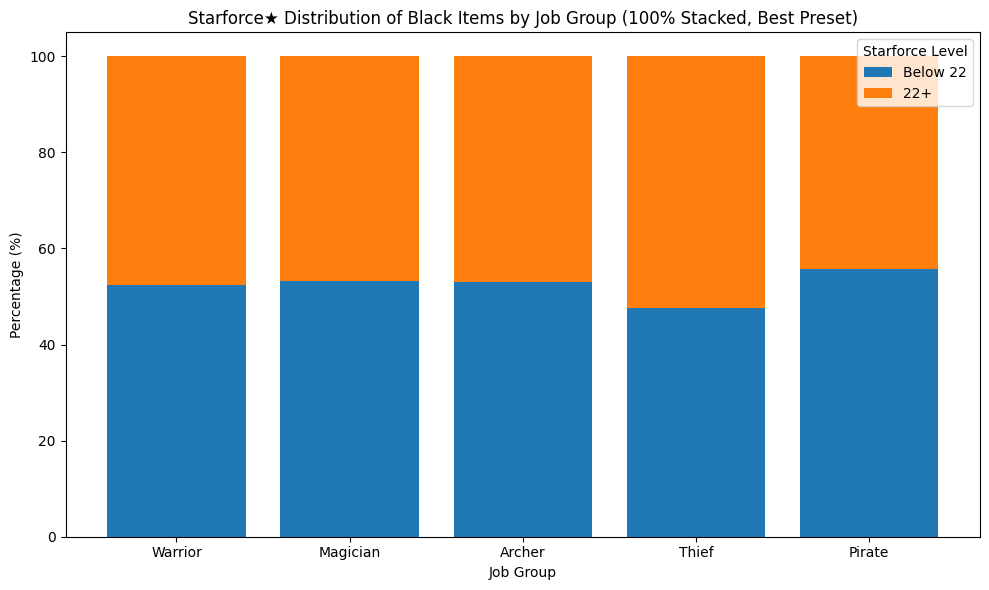

In [ ]:
# 직업군별로 살펴보기(비율)

# 유니코드 정규화 및 직업군 영어 매핑
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 칠흑 아이템 리스트
black_items = [
    "루즈 컨트롤 머신 마크", "마력이 깃든 안대", "블랙 하트", "컴플리트 언더컨트롤",
    "몽환의 벨트", "고통의 근원", "창세의 뱃지", "커맨더 포스 이어링",
    "거대한 공포", "저주받은 마도서", "미트라의 분노"
]

# 칠흑 아이템 필터링
black_eq_df = item_df_best[item_df_best["item_name"].isin(black_items)].copy()

# 스타포스 구간 분류
black_eq_df["starforce_group"] = black_eq_df["starforce"].apply(lambda x: "Below 22" if x < 22 else "22+")

# 직업군별 스타포스 구간 비율 계산
percent_df = (
    black_eq_df
    .groupby(["job_group_eng", "starforce_group"])
    .size()
    .unstack(fill_value=0)
    .reindex(["Warrior", "Magician", "Archer", "Thief", "Pirate"])
)

# 100% 누적 비율 변환
percent_df = percent_df.div(percent_df.sum(axis=1), axis=0) * 100

# 시각화
plt.figure(figsize=(10, 6))
bottom = None
colors = {"Below 22": "#1f77b4", "22+": "#ff7f0e"}

for label in ["Below 22", "22+"]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label=label,
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Starforce★ Distribution of Black Items by Job Group (100% Stacked, Best Preset)")
plt.xlabel("Job Group")
plt.ylabel("Percentage (%)")
plt.legend(title="Starforce Level")
plt.tight_layout()
plt.show()

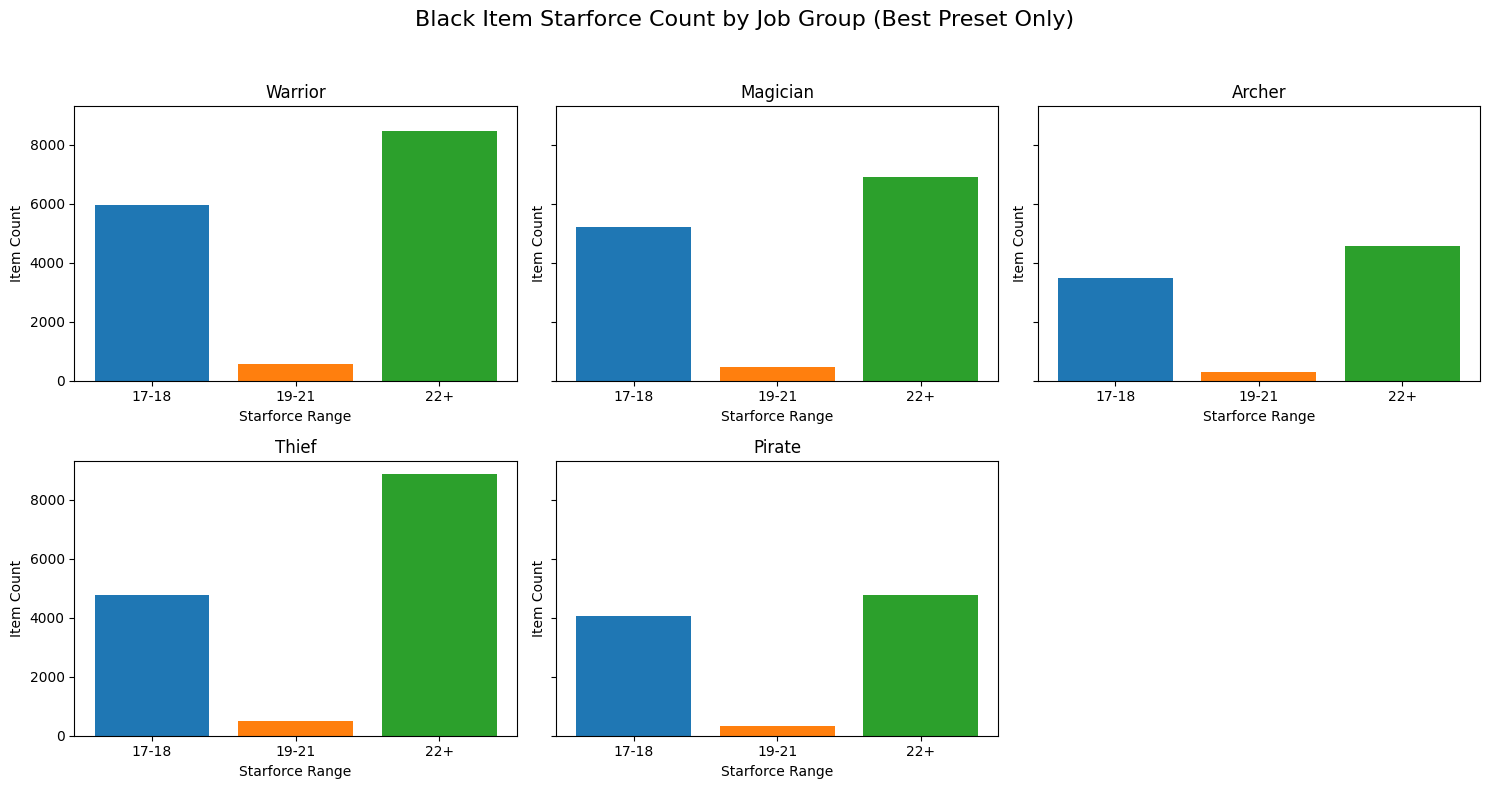

In [ ]:
# 스타포스 구간을 세분화한 후 직업군별로 살펴보기

# 유니코드 정규화 + 직업군 영어 매핑
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 칠흑 아이템 리스트
black_items = [
    "루즈 컨트롤 머신 마크", "마력이 깃든 안대", "블랙 하트", "컴플리트 언더컨트롤",
    "몽환의 벨트", "고통의 근원", "창세의 뱃지", "커맨더 포스 이어링",
    "거대한 공포", "저주받은 마도서", "미트라의 분노"
]

# 필터링
black_eq_df = item_df_best[item_df_best["item_name"].isin(black_items)].copy()

# 스타포스 구간 구분
def categorize_starforce(x):
    if x in [17, 18]:
        return "17-18"
    elif x in [19, 20, 21]:
        return "19-21"
    elif x >= 22:
        return "22+"
    else:
        return None

black_eq_df["starforce_range"] = black_eq_df["starforce"].apply(categorize_starforce)
filtered = black_eq_df[black_eq_df["starforce_range"].isin(["17-18", "19-21", "22+"])]

# 시각화
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
colors = {
    "17-18": "#1f77b4",
    "19-21": "#ff7f0e",
    "22+": "#2ca02c"
}

n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for idx, group in enumerate(job_groups):
    ax = axes[idx]
    sub = filtered[filtered["job_group_eng"] == group]
    count = sub["starforce_range"].value_counts().reindex(["17-18", "19-21", "22+"], fill_value=0)

    bars = ax.bar(count.index, count.values, color=[colors[r] for r in count.index])
    ax.set_title(group)
    ax.set_xlabel("Starforce Range")
    ax.set_ylabel("Item Count")
    ax.tick_params(axis="x", rotation=0)

    # for bar in bars:
    #     height = bar.get_height()
    #     ax.annotate(f"{int(height)}",
    #                 xy=(bar.get_x() + bar.get_width() / 2, height),
    #                 xytext=(0, 3),
    #                 textcoords="offset points",
    #                 ha="center", va="bottom", fontsize=9)

# 빈 subplot 제거
for j in range(len(job_groups), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Black Item Starforce Count by Job Group (Best Preset Only)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

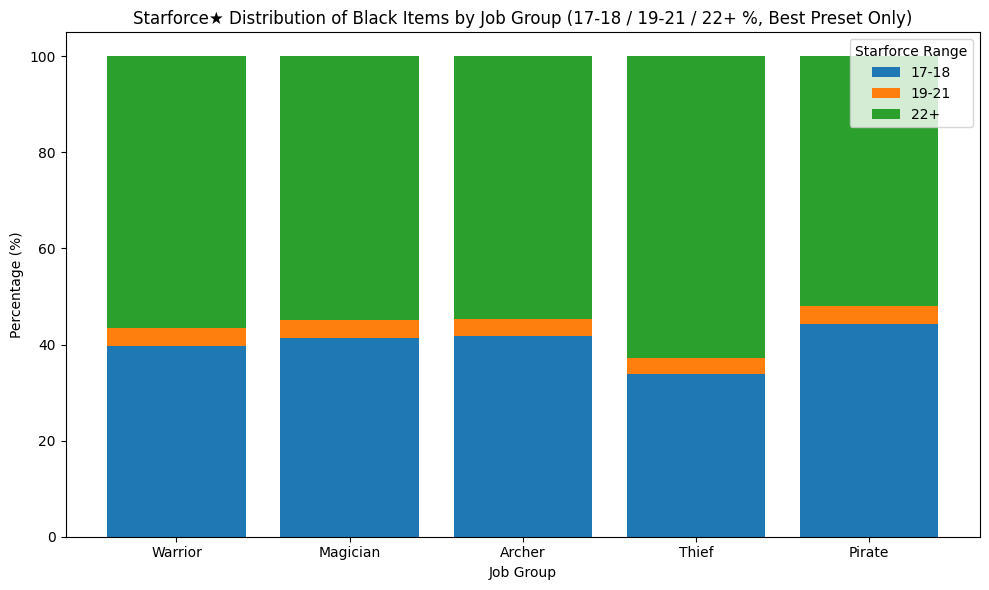

In [ ]:
# 스타포스 구간을 세분화한 후 직업군별로 살펴보기 (비율)

# 유니코드 정규화 + 직업군 영어 매핑
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 칠흑 아이템 리스트
black_items = [
    "루즈 컨트롤 머신 마크", "마력이 깃든 안대", "블랙 하트", "컴플리트 언더컨트롤",
    "몽환의 벨트", "고통의 근원", "창세의 뱃지", "커맨더 포스 이어링",
    "거대한 공포", "저주받은 마도서", "미트라의 분노"
]

# 필터링
black_eq_df = item_df_best[item_df_best["item_name"].isin(black_items)].copy()

# 스타포스 구간 나누기
def categorize_starforce(x):
    if x in [17, 18]:
        return "17-18"
    elif x in [19, 20, 21]:
        return "19-21"
    elif x >= 22:
        return "22+"
    else:
        return None

black_eq_df["starforce_range"] = black_eq_df["starforce"].apply(categorize_starforce)

# 유효한 범위만 필터링
filtered = black_eq_df[black_eq_df["starforce_range"].isin(["17-18", "19-21", "22+"])]

# 비율 집계
percent_df = (
    filtered
    .groupby(["job_group_eng", "starforce_range"])
    .size()
    .unstack(fill_value=0)
    .reindex(["Warrior", "Magician", "Archer", "Thief", "Pirate"])
)

# 비율 변환
percent_df = percent_df.div(percent_df.sum(axis=1), axis=0) * 100

# 색상 매핑
colors = {
    "17-18": "#1f77b4",   # 파란
    "19-21": "#ff7f0e",   # 주황
    "22+": "#2ca02c"      # 초록
}

# 시각화
plt.figure(figsize=(10, 6))
bottom = None
for label in ["17-18", "19-21", "22+"]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label=label,
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Starforce★ Distribution of Black Items by Job Group (17-18 / 19-21 / 22+ %, Best Preset Only)")
plt.xlabel("Job Group")
plt.ylabel("Percentage (%)")
plt.legend(title="Starforce Range")
plt.tight_layout()
plt.show()

시각화 결과: 22성 미만의 칠흑 아이템을 사용하는 유저가 더 많다. **(기존 가설
 = TRUE)**
- 그러나, 구간을 세분화하여 확인해보니 17-18성의 가성비 칠흑 아이템(흙칠흑)을 사용하는 유저보다는 22성 이상의 칠흑 아이템을 사용하는 유저가 더 많았다.
- 이는 모든 직업군에서 나타난 경향성이었다.

### 추론 통계

In [ ]:
# 전체 유저 기준: 카이제곱 적합도 검정

# 분포 수집
observed = black_eq_df["starforce_range"].value_counts()
expected = [sum(observed)/3] * 3  # 균등 분포 가정

# 적합도 검정
chi2, pval = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

Chi-square: 26067.869, p-value: 0.0000


- 귀무가설(H₀): 칠흑 아이템의 각 스타포스 강화 구간별 분포는 균등하다.
- 대립가설(H₁): 칠흑 아이템의 각 스타포스 강화 구간별 분포는 균등하지 않다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 칠흑 아이템의 각 스타포스 강화 구간별 분포가 균등하지 않다고 할 수 있다.**

In [ ]:
# 직업군별 차이: 카이제곱 독립성 검정

# 교차표 만들기
crosstab = pd.crosstab(black_eq_df["job_group_eng"], black_eq_df["starforce_range"])

# 독립성 검정
chi2, pval, dof, expected = stats.chi2_contingency(crosstab)
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

# 크래머의 V
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))
print(f"Cramér's V: {cramers_v:.4f}")

Chi-square: 334.013, p-value: 0.0000
Cramér's V: 0.0531


- 귀무가설(H₀): 직업군과 칠흑 아이템의 스타포스 강화 구간은 서로 독립이다.
(직업군에 상관없이 강화 구간 분포가 비슷함. 달라지지 않음)
- 대립가설(H₁): 직업군과 칠흑 아이템의 스타포스 강화 구간은 서로 독립이 아니다.
(직업군에 따라 강화 구간 분포가 다름)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 칠흑 아이템 강화 구간 분포가 다르다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.0531**로 관련성의 강도는 매우 약한 수준이었으며,
이는 **직업군에 따른 차이가 있긴 하지만, 실질적으로 강화 구간의 분포는 전체적으로 유사한 경향을 보인다는 점을 시사**한다.

### **최종 정리**
----
칠흑 아이템의 스타포스 강화 구간 분포는 통계적으로 균등하지 않으며,
특히 **22성 이상 강화한 칠흑 아이템 사용 비중이 가장 높게 나타났다.**

이러한 경향은 **직업군 간 미세한 차이가 있음에도 불구하고**,
전체적으로는 **전 직업군에 걸쳐 공통적으로 확인된 현상**이라고 해석할 수 있다.

## 가설 4
----
여명 아이템의 경우, 스타포스 22성 이상인 아이템을 사용하는 유저가 더 많을 것이다.

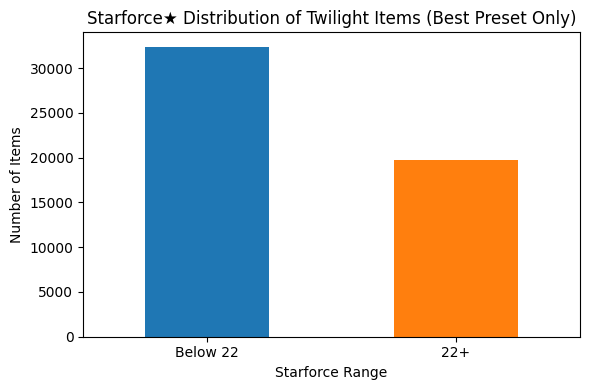

In [ ]:
# 여명 아이템 리스트
twilight_items = [
    "트와일라이트 마크",
    "에스텔라 이어링",
    "데이브레이크 펜던트",
    "여명의 가디언 엔젤 링"
]

# 필터링
twilight_df = item_df_best[item_df_best["item_name"].isin(twilight_items)].copy()

# 스타포스 구간 나누기
twilight_df["starforce_group"] = twilight_df["starforce"].apply(
    lambda x: "22+" if x >= 22 else "Below 22"
)

# 시각화
plt.figure(figsize=(6, 4))
twilight_df["starforce_group"].value_counts().reindex(["Below 22", "22+"], fill_value=0).plot(
    kind="bar", color=["#1f77b4", "#ff7f0e"]
)

plt.title("Starforce★ Distribution of Twilight Items (Best Preset Only)")
plt.xlabel("Starforce Range")
plt.ylabel("Number of Items")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

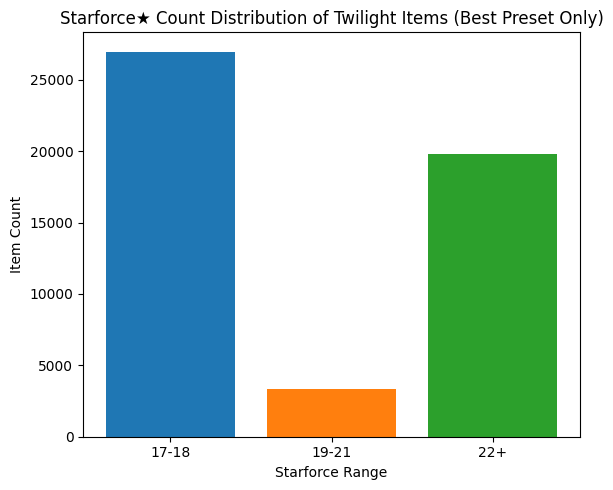

In [ ]:
# 스타포스 구간을 더 세분화하여 보기

# 여명 아이템 리스트
twilight_items = [
    "트와일라이트 마크",
    "에스텔라 이어링",
    "데이브레이크 펜던트",
    "여명의 가디언 엔젤 링"
]

# 여명 아이템 필터링
twilight_df = item_df_best[item_df_best["item_name"].isin(twilight_items)].copy()

# 스타포스 세부 구간 나누기
def categorize_starforce(x):
    if x in [17, 18]:
        return "17-18"
    elif x in [19, 20, 21]:
        return "19-21"
    elif x >= 22:
        return "22+"
    else:
        return None

twilight_df["starforce_range"] = twilight_df["starforce"].apply(categorize_starforce)

# 유효 구간 필터링
filtered = twilight_df[twilight_df["starforce_range"].isin(["17-18", "19-21", "22+"])]

# 구간별 개수 집계
starforce_counts = (
    filtered["starforce_range"]
    .value_counts()
    .reindex(["17-18", "19-21", "22+"], fill_value=0)
)

# 색상 매핑
colors = {
    "17-18": "#1f77b4",
    "19-21": "#ff7f0e",
    "22+": "#2ca02c"
}

# 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar(
    starforce_counts.index,
    starforce_counts.values,
    color=[colors[k] for k in starforce_counts.index]
)

# 수치 라벨 추가 (원하면 주석 해제)
# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f"{int(height)}",
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),
#                  textcoords="offset points",
#                  ha="center", va="bottom", fontsize=9)

plt.title("Starforce★ Count Distribution of Twilight Items (Best Preset Only)")
plt.xlabel("Starforce Range")
plt.ylabel("Item Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

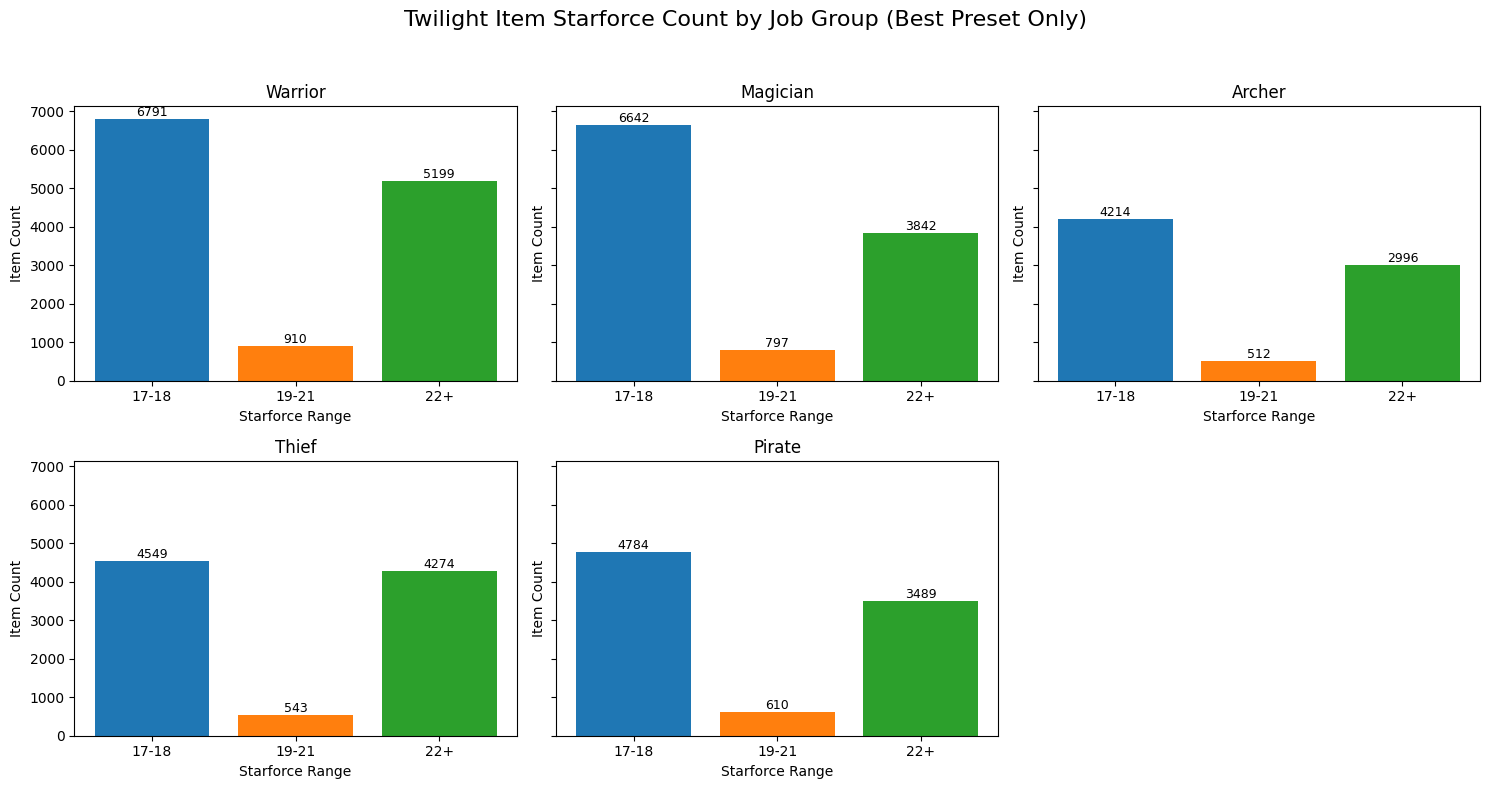

In [ ]:
# 스타포스 구간을 세분화한 후 직업군별로 살펴보기

# 유니코드 정규화 및 직업군 영어 매핑
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 여명 아이템 리스트
twilight_items = [
    "트와일라이트 마크", "에스텔라 이어링", "데이브레이크 펜던트", "여명의 가디언 엔젤 링"
]

# 여명 아이템 필터링
twilight_df = item_df_best[item_df_best["item_name"].isin(twilight_items)].copy()

# 스타포스 구간 나누기
def categorize_starforce(x):
    if x in [17, 18]:
        return "17-18"
    elif x in [19, 20, 21]:
        return "19-21"
    elif x >= 22:
        return "22+"
    else:
        return None

twilight_df["starforce_range"] = twilight_df["starforce"].apply(categorize_starforce)
filtered = twilight_df[twilight_df["starforce_range"].isin(["17-18", "19-21", "22+"])]
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]

# 시각화
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=True)
axes = axes.flatten()

colors = {
    "17-18": "#1f77b4",
    "19-21": "#ff7f0e",
    "22+": "#2ca02c"
}

for idx, group in enumerate(job_groups):
    ax = axes[idx]
    sub = filtered[filtered["job_group_eng"] == group]
    count = sub["starforce_range"].value_counts().reindex(["17-18", "19-21", "22+"], fill_value=0)
    bars = ax.bar(count.index, count.values, color=[colors[k] for k in count.index])

    ax.set_title(group)
    ax.set_xlabel("Starforce Range")
    ax.set_ylabel("Item Count")
    ax.tick_params(axis="x", rotation=0)

    # 수치 표시
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{int(height)}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 0.001),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=9)

# 빈 subplot 제거
for j in range(len(job_groups), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Twilight Item Starforce Count by Job Group (Best Preset Only)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

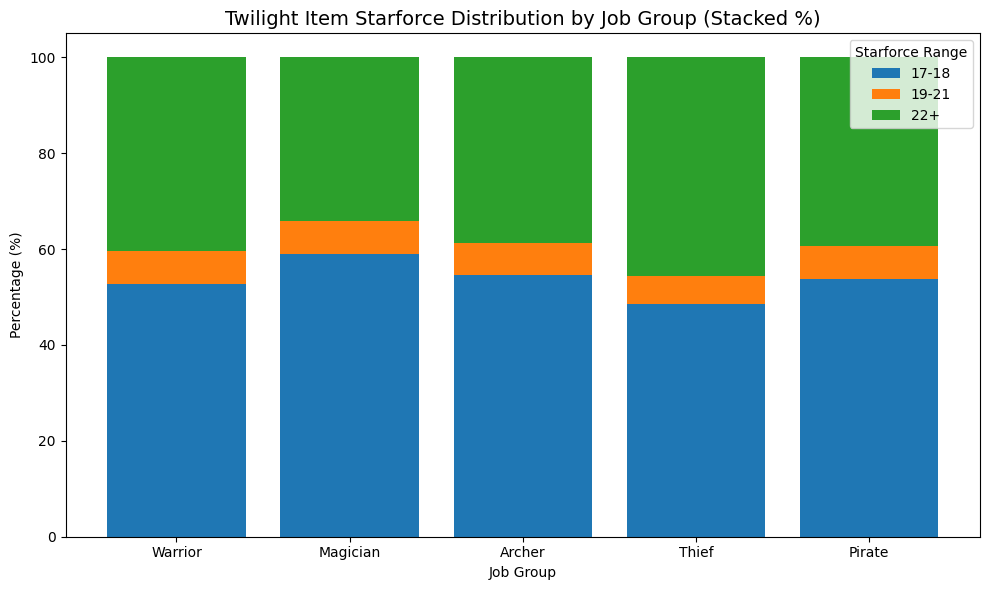

In [ ]:
# 스타포스 구간을 세분화한 후 직업군별로 살펴보기 (비율)

# 유니코드 정규화 및 직업군 영어 매핑
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 여명 아이템 리스트
twilight_items = [
    "트와일라이트 마크", "에스텔라 이어링", "데이브레이크 펜던트", "여명의 가디언 엔젤 링"
]

# 여명 아이템 필터링
twilight_df = item_df_best[item_df_best["item_name"].isin(twilight_items)].copy()

# 스타포스 구간 분류
def categorize_starforce(x):
    if x in [17, 18]:
        return "17-18"
    elif x in [19, 20, 21]:
        return "19-21"
    elif x >= 22:
        return "22+"
    else:
        return None

twilight_df["starforce_range"] = twilight_df["starforce"].apply(categorize_starforce)
filtered = twilight_df[twilight_df["starforce_range"].isin(["17-18", "19-21", "22+"])]

# 직업군 리스트 및 색상
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
colors = {
    "17-18": "#1f77b4",
    "19-21": "#ff7f0e",
    "22+": "#2ca02c"
}

# 집계 및 비율 계산
grouped = (
    filtered
    .groupby(["job_group_eng", "starforce_range"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=job_groups, columns=["17-18", "19-21", "22+"], fill_value=0)
)

percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100

# 시각화 (누적 바 차트)
plt.figure(figsize=(10, 6))
bottom = None
for label in ["17-18", "19-21", "22+"]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label=label,
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Twilight Item Starforce Distribution by Job Group (Stacked %)", fontsize=14)
plt.xlabel("Job Group")
plt.ylabel("Percentage (%)")
plt.legend(title="Starforce Range")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

시각화 결과: 22성 미만의 여명 아이템을 사용하는 유저가 더 많다. **(기존 가설 = FALSE)**
- 구간을 세분화하여 확인해보았을 때 17-18성의 여명 아이템을 사용하는 유저가 더 많았다.
- 이는 모든 직업군에서 나타난 경향성이었다.

### 추론 통계

In [ ]:
# 전체 유저 기준: 카이제곱 적합도 검정

# 관측값
observed = twilight_df["starforce_range"].value_counts()

# 기대값 (균등 분포 가정)
expected = [sum(observed)/3] * 3

# 적합도 검정
chi2, pval = chisquare(f_obs=observed, f_exp=expected)

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

Chi-square: 17522.118, p-value: 0.0000


- 귀무가설(H₀): 여명 아이템의 각 스타포스 강화 구간별 분포는 균등하다.
- 대립가설(H₁): 여명 아이템의 각 스타포스 강화 구간별 분포는 균등하지 않다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 여명 아이템의 각 스타포스 강화 구간별 분포는 균등하지 않다고 할 수 있다.**

In [ ]:
# 직업군별 차이: 카이제곱 독립성 검정

# 교차표
crosstab = pd.crosstab(twilight_df["job_group_eng"], twilight_df["starforce_range"])

# 독립성 검정
chi2, pval, dof, expected = stats.chi2_contingency(crosstab)
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

# 크래머의 V
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))
print(f"Cramér's V: {cramers_v:.4f}")

Chi-square: 299.195, p-value: 0.0000
Cramér's V: 0.0546


- 귀무가설(H₀): 직업군과 여명 아이템의 스타포스 강화 구간은 서로 독립이다.(직업군에 상관없이 강화 구간 분포가 비슷함. 달라지지 않음)
- 대립가설(H₁): 직업군과 여명 아이템의 스타포스 강화 구간은 서로 독립이 아니다.(직업군에 따라 강화 구간 분포가 다름)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 여명 아이템의 강화 구간별 분포 차이가 있다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.0546 수준의 매우 약한 관련성**으로, **강화 구간에 대한 유저들의 선택은 직업군과 크게 상관없이 공통된 패턴을 보이는 것으로 해석**할 수 있다.

### **최종 정리**
----
여명 아이템의 스타포스 강화 구간은 **통계적으로 유의하게 17~18성 구간에 집중되는 경향이 있었으며,**
이는 전체 유저들이 **여명 아이템을 고강(22성 이상)보다는 가성비 강화 수준으로 사용하는 것이 일반적임**을 보여준다.

직업군별로 여명 아이템의 스타포스 강화 구간마다 미묘한 분포 차이는 존재했지만,
**강화 추세는 직업군과 큰 상관 없이 전체적으로 일관된 패턴**을 보이는 것으로 분석되었다.

## 가설 5
----
앱솔랩스 장비를 사용하는 경우, 아케인 혹은 그 이상의 장비를 사용하는 유저들에 비해 22성의 개수가 더 많을 것이다.

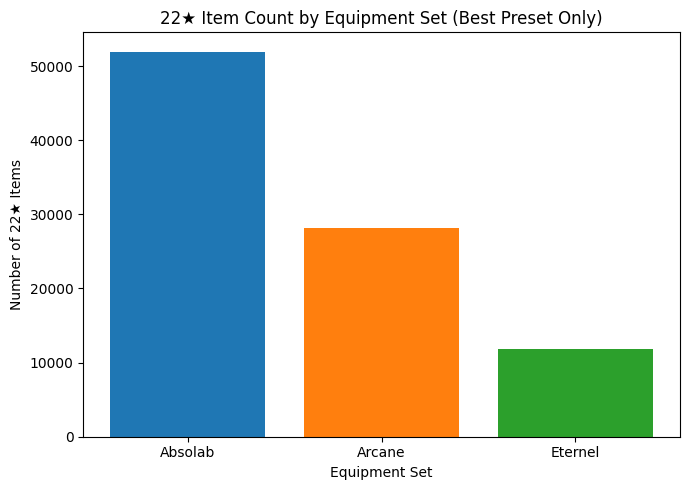

In [ ]:
# 장비 세트 그룹 정의
def map_equipment_group(name):
    if "앱솔랩스" in name:
        return "Absolab"
    elif "아케인셰이드" in name:
        return "Arcane"
    elif "에테르넬" in name:
        return "Eternel"
    return None

# 세트명 매핑 및 필터링
item_df_best["equip_group"] = item_df_best["item_name"].apply(map_equipment_group)
filtered = item_df_best[item_df_best["equip_group"].notnull()].copy()

# 22성 여부 컬럼 추가
filtered["is_22star"] = (filtered["starforce"] == 22).astype(int)

# 세트별 22성 장비 개수 집계
group_counts = (
    filtered
    .groupby("equip_group")["is_22star"]
    .sum()
    .reindex(["Absolab", "Arcane", "Eternel"], fill_value=0)
)

# 시각화
plt.figure(figsize=(7, 5))
bars = plt.bar(group_counts.index, group_counts.values, color=["#1f77b4", "#ff7f0e", "#2ca02c"])

# 수치 라벨 표시
# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f"{int(height):,}",  # 쉼표 포함 숫자 표시
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),
#                  textcoords="offset points",
#                  ha="center", va="bottom", fontsize=9)

plt.title("22★ Item Count by Equipment Set (Best Preset Only)")
plt.xlabel("Equipment Set")
plt.ylabel("Number of 22★ Items")
plt.tight_layout()
plt.show()

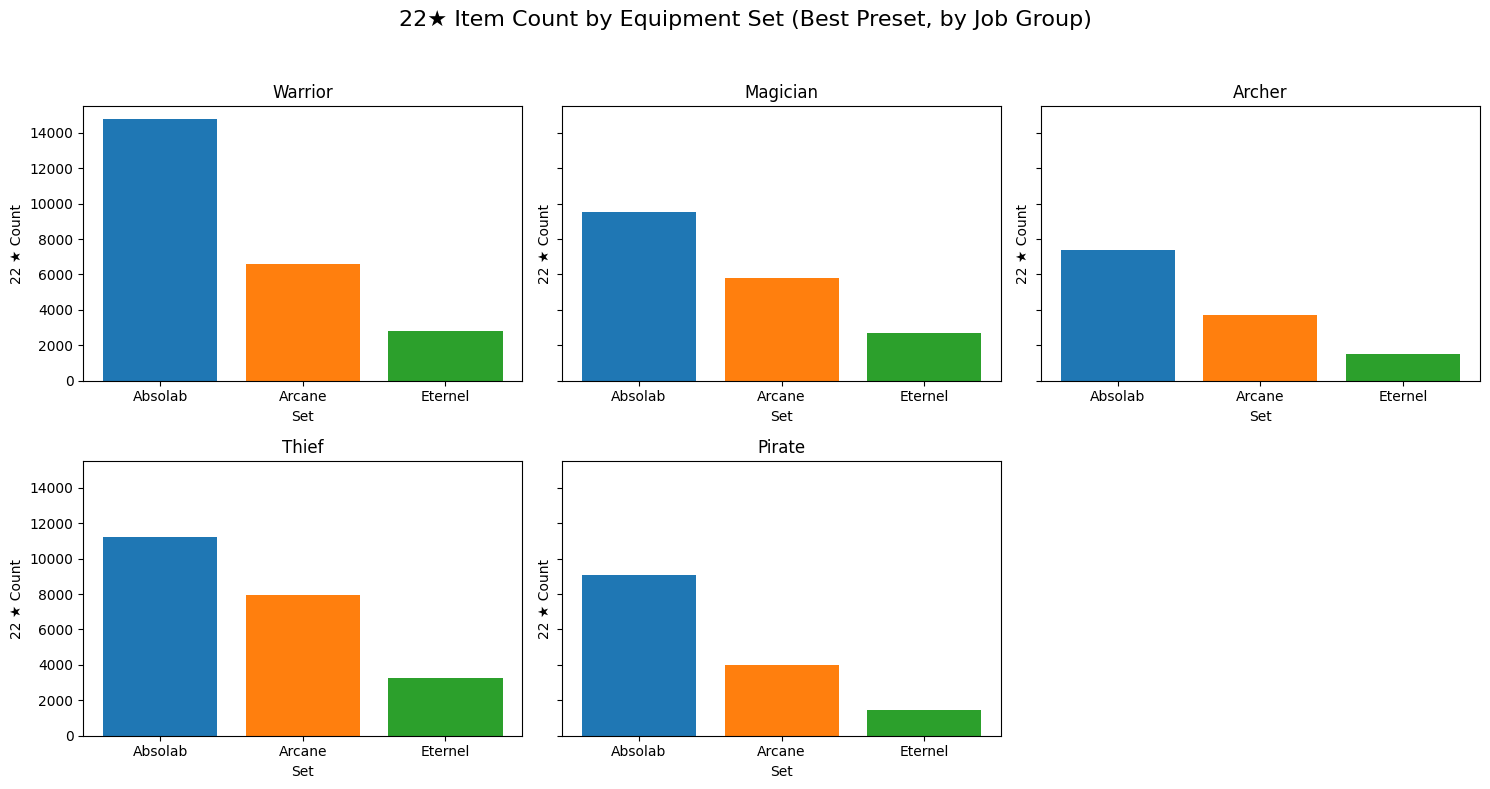

In [ ]:
# 직업군별로 살펴보기

# 유니코드 정규화 + 직업군 영어 매핑
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 장비 세트 분류
def map_equipment_group(name):
    if "앱솔랩스" in name:
        return "Absolab"
    elif "아케인셰이드" in name:
        return "Arcane"
    elif "에테르넬" in name:
        return "Eternel"
    return None

item_df_best["equip_group"] = item_df_best["item_name"].apply(map_equipment_group)
filtered = item_df_best[item_df_best["equip_group"].notnull()].copy()
filtered["is_22star"] = (filtered["starforce"] == 22).astype(int)

# 직업군 리스트
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
colors = {"Absolab": "#1f77b4", "Arcane": "#ff7f0e", "Eternel": "#2ca02c"}

# subplot 시각화
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for idx, group in enumerate(job_groups):
    ax = axes[idx]
    sub = filtered[filtered["job_group_eng"] == group]
    count = (
        sub.groupby("equip_group")["is_22star"]
        .sum()
        .reindex(["Absolab", "Arcane", "Eternel"], fill_value=0)
    )
    bars = ax.bar(count.index, count.values, color=[colors[k] for k in count.index])

    ax.set_title(group)
    ax.set_xlabel("Set")
    ax.set_ylabel("22 ★ Count")
    ax.tick_params(axis="x", rotation=0)

    # for bar in bars:
    #     height = bar.get_height()
    #     ax.annotate(f"{int(height):,}",  # 쉼표 있는 숫자
    #                 xy=(bar.get_x() + bar.get_width() / 2, height),
    #                 xytext=(0, 2),
    #                 textcoords="offset points",
    #                 ha="center", va="bottom", fontsize=9)

# 빈 subplot 제거
for j in range(len(job_groups), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("22★ Item Count by Equipment Set (Best Preset, by Job Group)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

시각화 결과: 앱솔랩스 장비에서 그 윗단계인 아케인셰이드, 에테르넬 장비에 비해 22성의 개수가 더 많다. **(기존 가설
 = TRUE)**
- 또한 모든 직업군에서 같은 경향성이 보였다.

### 추론 통계

In [ ]:
# 장비 등급과 강화 구간(22성 vs 미만) 사이의 독립성 여부 검정: 카이제곱 독립성 검정

# 교차표
crosstab = pd.crosstab(filtered["equip_group"], filtered["is_22star"])

# 카이제곱 검정
chi2, pval, dof, expected = chi2_contingency(crosstab)

# 크래머의 V
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cramér's V: {cramers_v:.4f}")

Chi-square: 16879.199, p-value: 0.0000
Cramér's V: 0.2820


- 귀무가설(H₀): 장비 등급과 22성 강화 여부는 서로 독립이다. (장비 등급에 상관없이 22성 강화 여부가 비슷함)
- 대립가설(H₁): 장비 등급과 22성 강화 여부는 서로 독립이 아니다. (장비 등급에 따라 22성 강화 여부가 달라짐)
  - **p-value < α(0.05)로, 대립가설을 채택하여 장비 등급에 따라 22성 강화 여부가 달라진다고 할 수 있다.**
  - 또한 **Cramér’s V = 0.2820**은 **두 변수 간의 관계 강도가 약한 수준에서 중간 수준에 가까운 명확한 경향성을 가진다**는 점을 보여주며,
이는 **장비 강화 전략에서 등급에 따른 뚜렷한 경향성이 실질적으로 존재함**을 의미한다.

In [ ]:
# 직업군마다 이러한 경향이 일관되게 나타나는가?: 직업군별로 개별 카이제곱 독립성 검정
job_groups = filtered["job_group_eng"].unique()

results = []

for job in job_groups:
    subset = filtered[filtered["job_group_eng"] == job]
    table = pd.crosstab(subset["equip_group"], subset["is_22star"])

    if table.shape[0] > 1 and table.shape[1] > 1:  # 예외 처리
        chi2, pval, dof, expected = chi2_contingency(table)

        results.append({
            "job_group": job,
            "chi2": chi2,
            "p_value": pval,
            "significant": pval < 0.05
        })

pd.DataFrame(results)

,job_group,chi2,p_value,significant
0,Pirate,4606.490601,0.0,True
1,Warrior,4416.813702,0.0,True
2,Archer,2666.146313,0.0,True
3,Thief,3195.452344,0.0,True
4,Magician,2680.703522,0.0,True


- 귀무가설(H₀): 장비 등급과 22성 강화 여부는 서로 독립이다. (장비 등급에 상관없이 22성 강화 여부가 비슷함)
- 대립가설(H₁): 장비 등급과 22성 강화 여부는 서로 독립이 아니다. (장비 등급에 따라 22성 강화 여부가 달라짐)
  - **모든 직업군에서 p-value < α(0.05)로, 대립가설을 채택하여 각 직업군 내에서
장비 등급과 22성 강화 여부는 통계적으로 유의미하게 관련되어 있다고 할 수 있다.**

### **최종 정리**
----
장비 등급이 낮을수록 유저들이 **22성 아이템을 더 적극적으로 사용하는 경향**이 존재하며,
이 경향은 전체 유저는 물론, **모든 직업군에서 일관되게 확인**되었다.

특히 앱솔랩스 장비의 경우, **강화 비용 대비 효율, 접근성, 강화 난이도** 등 다양한 요인을 고려한
**전략적 선택의 결과로 22성 비율이 유의미하게 높게 나타난 것**으로 해석할 수 있다.

결과적으로, **장비 강화 전략에서 ‘장비 등급’은 실질적으로 매우 중요한 영향 요인**임이 통계적으로 뒷받침되었다.

# 아이템 관련: 주문서

## 가설 6
----
방어구에 주문의 흔적 15%작을 한 유저가 30%, 70%, 100%작을 한 유저보다 많을 것이다.

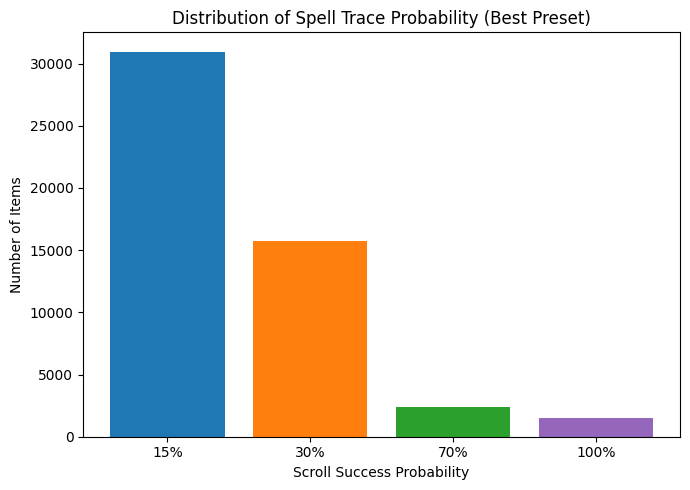

In [ ]:
# 방어구 필터링
armor_parts = ["모자", "상의", "하의", "장갑", "신발", "망토", "어깨장식"] # 한벌옷은 거의 사용하지 않기 때문에 제외
armor_df = item_df_best[item_df_best["equipment_part"].isin(armor_parts)].copy()

# 직업별 주스탯 매핑
main_stat_map = {
    "STR": ["아델", "소울마스터", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

# 주스탯 구분
def get_main_stat(row):
    for stat, job_list in main_stat_map.items():
        if row["job"] in job_list:
            return stat
    return None

armor_df["main_stat_type"] = armor_df.apply(get_main_stat, axis=1)

# 주스탯 기준 주문서 스탯 상승량 계산
def calc_scroll_stat(row):
    stat = row["main_stat_type"]
    if stat == "STR":
        return row["str_etc"]
    elif stat == "DEX":
        return row["dex_etc"]
    elif stat == "INT":
        return row["int_etc"]
    elif stat == "LUK":
        return row["luk_etc"]
    elif stat == "HP":
        return 0
    elif stat == "ALL":
        return row["str_etc"] + row["dex_etc"] + row["luk_etc"]
    return 0

armor_df["scroll_stat_total"] = armor_df.apply(calc_scroll_stat, axis=1)

# 평균 1작당 스탯 상승량 계산
armor_df["avg_stat_per_upgrade"] = armor_df["scroll_stat_total"] / armor_df["scroll_upgrade"]

# 확률 추정
def determine_scroll_type(stat):
    if stat == 10:
        return "15%"
    elif stat == 7:
        return "30%"
    elif stat == 4:
        return "70%"
    elif stat == 3:
        return "100%"
    return None

armor_df["scroll_type"] = armor_df["avg_stat_per_upgrade"].apply(determine_scroll_type)

# 유효한 값만 필터링
valid_scrolls = armor_df[armor_df["scroll_type"].notnull()].copy()

# 집계 및 시각화
scroll_distribution = valid_scrolls["scroll_type"].value_counts().reindex(["15%", "30%", "70%", "100%"], fill_value=0)

plt.figure(figsize=(7, 5))
bars = plt.bar(scroll_distribution.index, scroll_distribution.values,
               color=["#1f77b4", "#ff7f0e", "#2ca02c", "#9467bd"])

# 수치 표시
# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f"{int(height):,}",
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),
#                  textcoords="offset points",
#                  ha="center", va="bottom", fontsize=9)

plt.title("Distribution of Spell Trace Probability (Best Preset)")
plt.xlabel("Scroll Success Probability")
plt.ylabel("Number of Items")
plt.tight_layout()
plt.show()

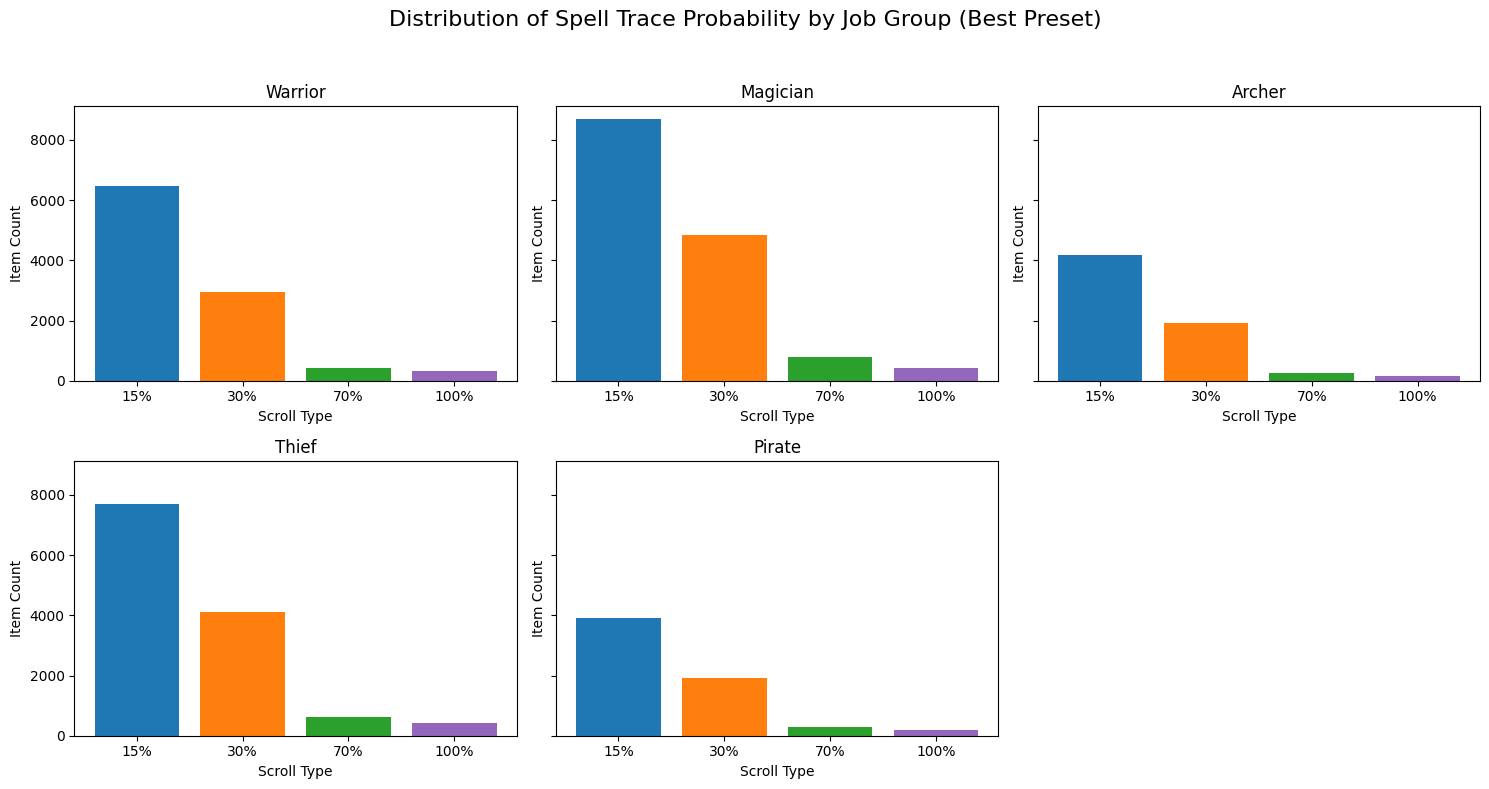

In [ ]:
# 직업군별로 살펴보기

# 유니코드 정규화 및 직업군 영문화
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 방어구 필터링
armor_parts = ["모자", "상의", "하의", "장갑", "신발", "망토", "어깨장식"]
armor_df = item_df_best[item_df_best["equipment_part"].isin(armor_parts)].copy()

# 주스탯 매핑
main_stat_map = {
    "STR": ["아델", "소울마스터", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

def get_main_stat(row):
    for stat, job_list in main_stat_map.items():
        if row["job"] in job_list:
            return stat
    return None

armor_df["main_stat_type"] = armor_df.apply(get_main_stat, axis=1)

# 주스탯 기준 주문서 스탯 계산
def calc_scroll_stat(row):
    stat = row["main_stat_type"]
    if stat == "STR":
        return row["str_etc"]
    elif stat == "DEX":
        return row["dex_etc"]
    elif stat == "INT":
        return row["int_etc"]
    elif stat == "LUK":
        return row["luk_etc"]
    elif stat == "HP":
        return 0
    elif stat == "ALL":
        return row["str_etc"] + row["dex_etc"] + row["luk_etc"]
    return 0

armor_df["scroll_stat_total"] = armor_df.apply(calc_scroll_stat, axis=1)
armor_df["avg_stat_per_upgrade"] = armor_df["scroll_stat_total"] / armor_df["scroll_upgrade"]

def determine_scroll_type(stat):
    if stat == 10:
        return "15%"
    elif stat == 7:
        return "30%"
    elif stat == 4:
        return "70%"
    elif stat == 3:
        return "100%"
    return None

armor_df["scroll_type"] = armor_df["avg_stat_per_upgrade"].apply(determine_scroll_type)
valid_scrolls = armor_df[armor_df["scroll_type"].notnull()].copy()

# 직업군 리스트 및 색상 설정
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
colors = {"15%": "#1f77b4", "30%": "#ff7f0e", "70%": "#2ca02c", "100%": "#9467bd"}

# 시각화
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharey=True)
axes = axes.flatten()

for idx, group in enumerate(job_groups):
    ax = axes[idx]
    sub = valid_scrolls[valid_scrolls["job_group_eng"] == group]
    count = sub["scroll_type"].value_counts().reindex(["15%", "30%", "70%", "100%"], fill_value=0)
    bars = ax.bar(count.index, count.values, color=[colors[k] for k in count.index])

    ax.set_title(group)
    ax.set_xlabel("Scroll Type")
    ax.set_ylabel("Item Count")
    ax.tick_params(axis="x", rotation=0)

    # for bar in bars:
    #     height = bar.get_height()
    #     ax.annotate(f"{int(height):,}",
    #                 xy=(bar.get_x() + bar.get_width() / 2, height),
    #                 xytext=(0, 3),
    #                 textcoords="offset points",
    #                 ha="center", va="bottom", fontsize=9)

# 빈 subplot 제거
for j in range(len(job_groups), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Spell Trace Probability by Job Group (Best Preset)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

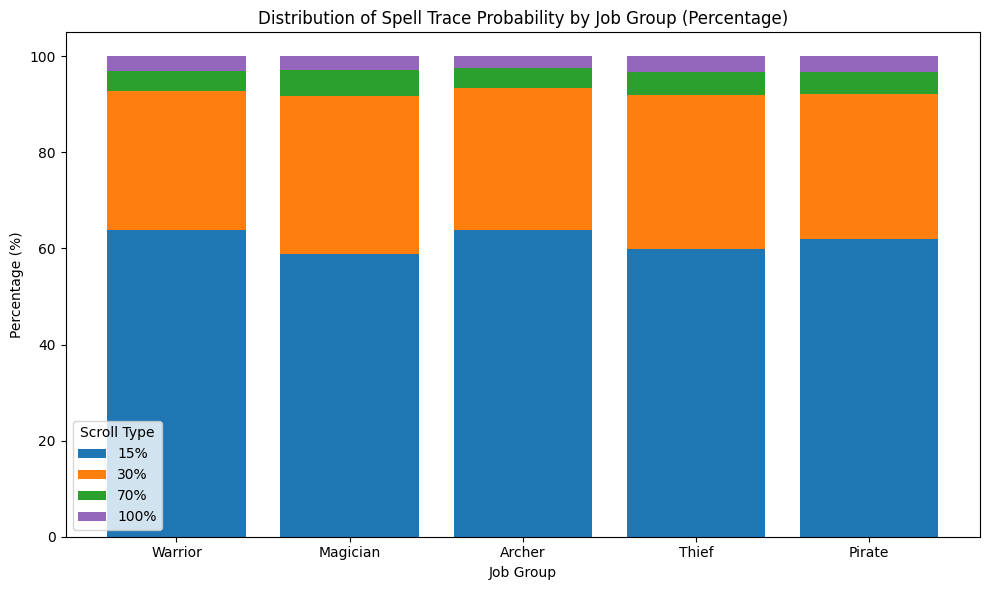

In [ ]:
# 직업군별로 살펴보기 (비율)

# 유니코드 정규화 + 직업군 영어화
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))
group_map = {
    "전사": "Warrior", "마법사": "Magician", "궁수": "Archer", "도적": "Thief", "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(group_map)

# 방어구 부위
armor_parts = ["모자", "상의", "하의", "장갑", "신발", "망토", "어깨장식"]
armor_df = item_df_best[item_df_best["equipment_part"].isin(armor_parts)].copy()

# 주스탯 매핑
main_stat_map = {
    "STR": ["아델", "소울마스터", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

armor_df["main_stat_type"] = armor_df.apply(get_main_stat, axis=1)

# 주문서 스탯 계산
def calc_scroll_stat(row):
    stat = row["main_stat_type"]
    if stat == "STR":
        return row["str_etc"]
    elif stat == "DEX":
        return row["dex_etc"]
    elif stat == "INT":
        return row["int_etc"]
    elif stat == "LUK":
        return row["luk_etc"]
    elif stat == "HP":
        return 0
    elif stat == "ALL":
        return row["str_etc"] + row["dex_etc"] + row["luk_etc"]
    return 0

armor_df["scroll_stat_total"] = armor_df.apply(calc_scroll_stat, axis=1)
armor_df["avg_stat_per_upgrade"] = armor_df["scroll_stat_total"] / armor_df["scroll_upgrade"]

# 주문서 타입 분류
def determine_scroll_type(stat):
    if stat == 10:
        return "15%"
    elif stat == 7:
        return "30%"
    elif stat == 4:
        return "70%"
    elif stat == 3:
        return "100%"
    return None

armor_df["scroll_type"] = armor_df["avg_stat_per_upgrade"].apply(determine_scroll_type)
valid_scrolls = armor_df[armor_df["scroll_type"].notnull()].copy()

# 집계 → 비율 변환
job_groups = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]
colors = {"15%": "#1f77b4", "30%": "#ff7f0e", "70%": "#2ca02c", "100%": "#9467bd"}

ratio_df = (
    valid_scrolls.groupby(["job_group_eng", "scroll_type"])
    .size()
    .unstack(fill_value=0)
    .reindex(index=job_groups, columns=["15%", "30%", "70%", "100%"])
)

percent_df = ratio_df.div(ratio_df.sum(axis=1), axis=0) * 100

# 시각화
plt.figure(figsize=(10, 6))
bottom = None
for label in ["15%", "30%", "70%", "100%"]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label=label,
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Distribution of Spell Trace Probability by Job Group (Percentage)")
plt.xlabel("Job Group")
plt.ylabel("Percentage (%)")
plt.legend(title="Scroll Type")
plt.tight_layout()
plt.show()

시각화 결과: 방어구에 주문의 흔적으로 주문서작을 했을 때, 15%작을 한 유저들이 가장 많다. **(기존 가설
 = TRUE)**
- 모든 직업군에서 같은 경향성이 보였다.
- 70%작을 하는 뉴비 유저들과 다르게 고레벨 유저들은 15%, 30% 아이템을 사용하는 경향이 있음을 확인하였다.

### 추론 통계

In [ ]:
# 전체 유저 기준: 카이제곱 적합도 검정

rate_counts = valid_scrolls["scroll_type"].value_counts().reindex(["15%", "30%", "70%", "100%"], fill_value=0)
observed = rate_counts.values
expected = [sum(observed)/4] * 4  # 균등 분포 기대값

chi2, pval = chisquare(f_obs=observed, f_exp=expected)
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")

Chi-square: 45331.517, p-value: 0.0000


- 귀무가설(H₀): 방어구에 사용된 주문의 흔적 성공률 분포는 균등하다.
(즉, 15%, 30%, 70%, 100%를 비슷한 비율로 사용한다.)
- 대립가설(H₁): 방어구에 사용된 주문의 흔적 성공률 분포는 균등하지 않다.
(즉, 특정 성공률에 유저가 몰리는 경향이 있다 — 특히 15%)
  - **p-value < α(0.05)로, 대립가설을 채택하여 특정 강화 성공률(15%)에 쏠림이 유의미하게 존재한다고 할 수 있다.**

In [ ]:
# 직업군별 비교: 카이제곱 독립성 검정

# 교차표 생성
crosstab = pd.crosstab(valid_scrolls["job_group_eng"], valid_scrolls["scroll_type"])

# 검정
chi2, pval, dof, expected = chi2_contingency(crosstab)

# 크래머의 V
import numpy as np
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cramér’s V: {cramers_v:.4f}")

Chi-square: 109.289, p-value: 0.0000
Cramér’s V: 0.0268


- 귀무가설(H₀): 직업군과 주문의 흔적 성공률은 서로 독립이다.
(직업군이 달라도 사용하는 주문의 흔적 성공률 분포는 비슷)
- 대립가설(H₁): 직업군과 주문의 흔적 성공률은 서로 독립이 아니다. (직업군마다 사용하는 주문의 흔적 성공률 분포가 다를 것)
  - **p-value < α(0.05)로, 대립가설을 채택하여 헥사 메인스탯 7강 미만 유저가 더 많다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.0268**로, 두 변수 간 관계 강도는 **매우 약한 수준**이었으며,
이는 **직업군에 따른 주문서 선택 경향의 차이는 통계적으로는 존재하지만, 실질적인 영향은 미미함을 시사**한다.

### **최종 정리**
----
전체적으로 유저들은 방어구 강화 시 **15% 주문서를 가장 많이 선택**하는 경향을 보이며,
이 선택은 **모든 직업군에서 공통적으로 나타나는 전략적 패턴**으로 해석된다.

직업군별 차이는 존재했지만, **그 강도는 미미**하므로
주문서 선택은 직업 특성보다는 **유저의 전반적인 강화 효율 판단과 위험-보상 전략**에 의해 결정되는 것으로 볼 수 있다.

# 아이템 관련: 잠재능력 + 에디셔널 잠재능력

## 가설 7
----
잠재능력의 경우, 직업별 주스탯 %가 21% 이상인 유저가 그렇지 않은 유저보다 더 많을 것이다.

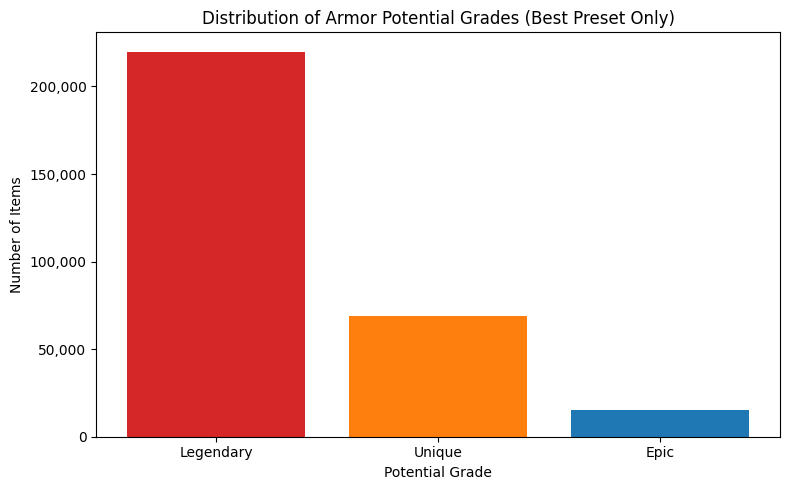

In [ ]:
# 먼저, 고레벨 유저들은 어떤 등급의 잠재능력이 붙은 방어구를 많이 사용하고 있을까?

# 등급 변환 맵핑
grade_map = {
    "레전드리": "Legendary",
    "유니크": "Unique",
    "에픽": "Epic"
}

# 방어구 필터링
armor_parts = ["모자", "상의", "하의", "장갑", "신발", "망토", "어깨장식"] # 한벌옷은 거의 사용하지 않기 때문에 제외
armor_df = item_df_best[item_df_best["equipment_part"].isin(armor_parts)].copy()

# 영어 등급으로 매핑
armor_df["potential_grade_eng"] = armor_df["potential_option_grade"].map(grade_map)

# 레전드리, 유니크, 에픽만 필터링 후 개수 집계
filtered = armor_df[armor_df["potential_grade_eng"].notnull()]
grade_counts = filtered["potential_grade_eng"].value_counts().reindex(["Legendary", "Unique", "Epic"], fill_value=0)

# 시각화
plt.figure(figsize=(8, 5))
colors = ["#d62728", "#ff7f0e", "#1f77b4"]
bars = plt.bar(grade_counts.index, grade_counts.values, color=colors)

# 수치 표시
# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f"{height:,}",
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),
#                  textcoords="offset points",
#                  ha="center", va="bottom", fontsize=10)

# Y축 포맷도 쉼표 포함 형식으로
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.title("Distribution of Armor Potential Grades (Best Preset Only)")
plt.xlabel("Potential Grade")
plt.ylabel("Number of Items")
plt.tight_layout()
plt.show()

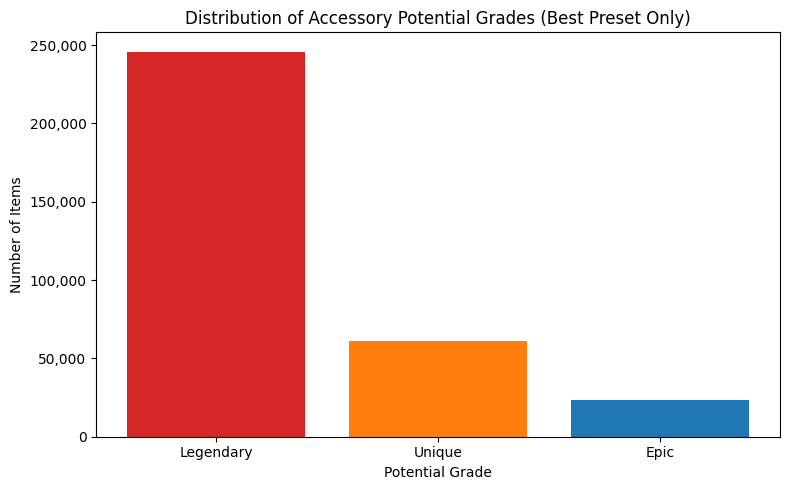

In [ ]:
# 먼저, 고레벨 유저들은 어떤 등급의 잠재능력이 붙은 장신구를 많이 사용하고 있을까?

# 장신구 부위
accessory_parts = [
    "눈장식", "얼굴장식", "벨트", "펜던트", "귀고리", "반지",
    "기계 심장", "엠블렘" # 포켓 아이템과 뱃지는 잠재능력 설정 불가하기 때문에 제외
]

# 잠재능력 등급 맵핑
grade_map = {
    "레전드리": "Legendary",
    "유니크": "Unique",
    "에픽": "Epic"
}

# 장신구 필터링
acc_df = item_df_best[item_df_best["equipment_part"].isin(accessory_parts)].copy()
acc_df["potential_grade_eng"] = acc_df["potential_option_grade"].map(grade_map)

# 등급 필터링 및 집계
filtered = acc_df[acc_df["potential_grade_eng"].notnull()]
grade_counts = filtered["potential_grade_eng"].value_counts().reindex(["Legendary", "Unique", "Epic"], fill_value=0)

# 시각화
plt.figure(figsize=(8, 5))
colors = ["#d62728", "#ff7f0e", "#1f77b4"]
bars = plt.bar(grade_counts.index, grade_counts.values, color=colors)

# 수치 표시
# for bar in bars:
#     height = bar.get_height()
#     plt.annotate(f"{height:,}",  # 쉼표 포함 포맷
#                  xy=(bar.get_x() + bar.get_width() / 2, height),
#                  xytext=(0, 3),
#                  textcoords="offset points",
#                  ha="center", va="bottom", fontsize=10)

# y축 쉼표 포맷
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.title("Distribution of Accessory Potential Grades (Best Preset Only)")
plt.xlabel("Potential Grade")
plt.ylabel("Number of Items")
plt.tight_layout()
plt.show()

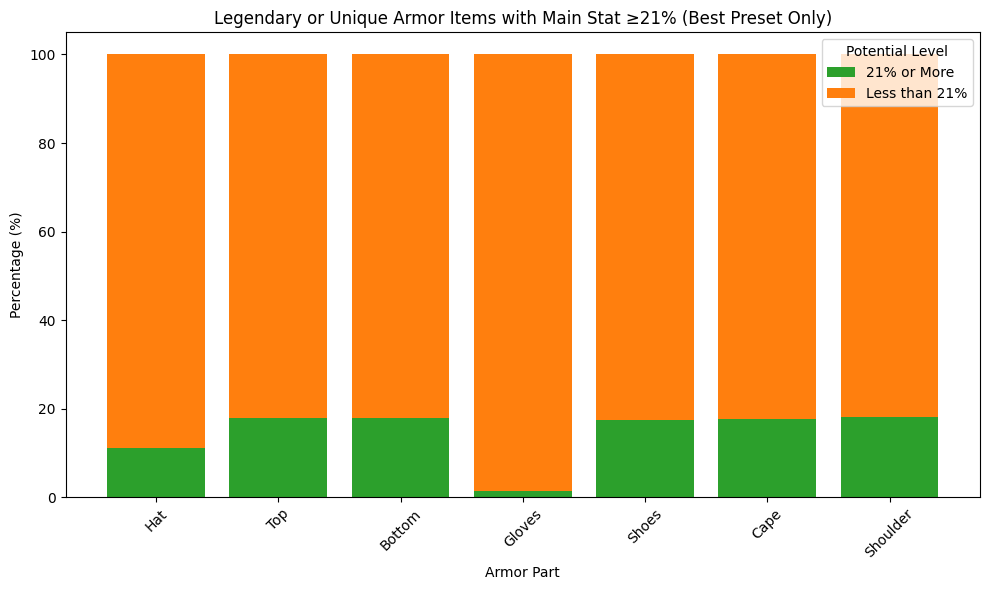

In [ ]:
# 잠재능력 레전드리 or 유니크 등급의 방어구에서 주스탯 21% 이상의 옵션을 사용하는 유저들이 많을까?

# 방어구 부위 한글 → 영어 매핑
armor_name_map = {
    "모자": "Hat",
    "상의": "Top",
    "하의": "Bottom",
    "장갑": "Gloves",
    "신발": "Shoes",
    "망토": "Cape",
    "어깨장식": "Shoulder"
}
armor_parts = list(armor_name_map.keys())

# 직업별 주스탯 매핑
main_stat_map = {
    "STR": ["아델", "소울마스터", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

# 주스탯 판별
def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

# 주스탯 % 추출 함수
def extract_percent(option, stat):
    if pd.isna(option): return 0
    target = f"{stat} : +"
    if target in option and "%" in option:
        try:
            return int(option.split(target)[-1].replace("%", ""))
        except:
            return 0
    return 0

def calc_total_percent(row):
    stat = row["main_stat_type"]
    if not stat or stat == "HP":
        return 0
    return sum(extract_percent(row[col], stat) for col in ["potential_option_1", "potential_option_2", "potential_option_3"])

# 필터링
legend_unique_df = item_df_best[
    (item_df_best["equipment_part"].isin(armor_parts)) &
    (item_df_best["potential_option_grade"].isin(["레전드리", "유니크"]))
].copy()

legend_unique_df["main_stat_type"] = legend_unique_df.apply(get_main_stat, axis=1)
legend_unique_df["main_stat_percent"] = legend_unique_df.apply(calc_total_percent, axis=1)
legend_unique_df["over_21"] = legend_unique_df["main_stat_percent"] >= 21
legend_unique_df["equipment_part_eng"] = legend_unique_df["equipment_part"].map(armor_name_map)

# 집계
part_group = legend_unique_df.groupby(["equipment_part_eng", "over_21"]).size().unstack().fillna(0)
percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex([armor_name_map[k] for k in armor_parts])  # 순서 유지

# 시각화
plt.figure(figsize=(10, 6))
colors = {True: "#2ca02c", False: "#ff7f0e"}
bottom = None

for label in [True, False]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="21% or More" if label else "Less than 21%",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Legendary or Unique Armor Items with Main Stat ≥21% (Best Preset Only)")
plt.ylabel("Percentage (%)")
plt.xlabel("Armor Part")
plt.xticks(rotation=45)
plt.legend(title="Potential Level")
plt.tight_layout()
plt.show()

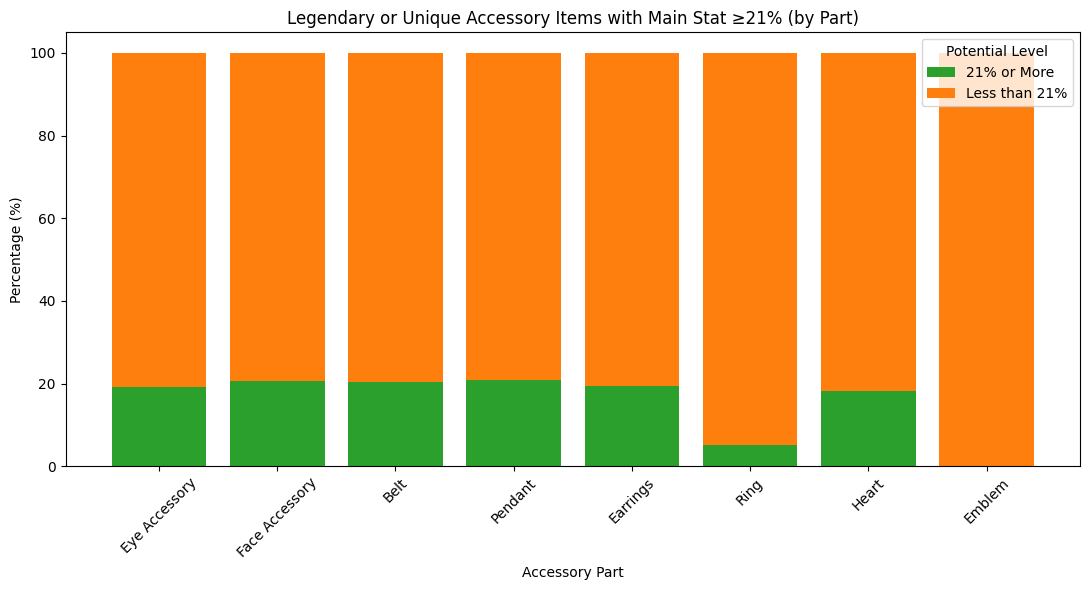

In [ ]:
# 잠재능력 레전드리 or 유니크 등급의 장신구에서 주스탯 21% 이상의 옵션을 사용하는 유저들이 많을까?

# 장신구 한글 → 영어 매핑
accessory_name_map = {
    "눈장식": "Eye Accessory",
    "얼굴장식": "Face Accessory",
    "벨트": "Belt",
    "펜던트": "Pendant",
    "귀고리": "Earrings",
    "반지": "Ring",
    "기계 심장": "Heart",
    "엠블렘": "Emblem"
}
accessory_parts = list(accessory_name_map.keys())

# 직업별 주스탯 매핑
main_stat_map = {
    "STR": ["아델", "소울마스터", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

def get_main_stat(row):
    job_name = row["job"]
    for stat, job_list in main_stat_map.items():
        if job_name in job_list:
            return stat
    return None

# 특수 능력 반지 이름 목록 -> 잠재능력이 붙지 않는 특수 능력 반지는 시각화에서 제외
special_rings = [
    "리스트레인트 링", "리스크테이커 링", "크라이시스-HM링", "컨티뉴어스 링",
    "웨폰퍼프-S링", "웨폰퍼프-D링", "웨폰퍼프-I링", "웨폰퍼프-L링",
    "레벨퍼프-S링", "레벨퍼프-D링", "레벨퍼프-I링", "레벨퍼프-L링",
    "링 오브 썸", "듀라빌리티 링",
    "얼티메이덤 링", "크리데미지 링", "크라이시스-H링", "크라이시스-M링",
    "크리디펜스 링", "스위프트 링", "헬스컷 링", "마나컷 링", "리밋 링",
    "실드스와프 링", "크리쉬프트 링", "스탠스쉬프트 링",
    "타워인헨스 링", "오버패스 링", "리플렉티브 링",
    "버든리프트 링", "리커버디펜스 링", "리커버스탠스 링"
]

# 레전드리 또는 유니크 등급 + 특수 능력 반지 제외
legend_acc_df = item_df_best[
    (item_df_best["equipment_part"].isin(accessory_parts)) &
    (item_df_best["potential_option_grade"].isin(["레전드리", "유니크"])) &
    ~((item_df_best["equipment_part"] == "반지") & (item_df_best["item_name"].isin(special_rings)))
].copy()

# 주스탯 매핑
legend_acc_df["main_stat_type"] = legend_acc_df.apply(get_main_stat, axis=1)

# 주스탯 % 추출 함수
def extract_percent(option, stat):
    if pd.isna(option): return 0
    target = f"{stat} : +"
    if target in option and "%" in option:
        try:
            return int(option.split(target)[-1].replace("%", ""))
        except:
            return 0
    return 0

# 총합 계산
def calc_total_percent(row):
    stat = row["main_stat_type"]
    if not stat or stat == "HP": return 0
    return sum(extract_percent(row[col], stat) for col in ["potential_option_1", "potential_option_2", "potential_option_3"])

legend_acc_df["main_stat_percent"] = legend_acc_df.apply(calc_total_percent, axis=1)
legend_acc_df["over_21"] = legend_acc_df["main_stat_percent"] >= 21

# 부위 영어로 매핑
legend_acc_df["equipment_part_eng"] = legend_acc_df["equipment_part"].map(accessory_name_map)

# 부위별 비율 계산
grouped = legend_acc_df.groupby(["equipment_part_eng", "over_21"]).size().unstack().fillna(0)
percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex([accessory_name_map[k] for k in accessory_parts])  # 순서 고정

# 누적 바 시각화
plt.figure(figsize=(11, 6))
colors = {True: "#2ca02c", False: "#ff7f0e"}
bottom = None

for label in [True, False]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="21% or More" if label else "Less than 21%",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Legendary or Unique Accessory Items with Main Stat ≥21% (by Part)")
plt.ylabel("Percentage (%)")
plt.xlabel("Accessory Part")
plt.xticks(rotation=45)
plt.legend(title="Potential Level")
plt.tight_layout()
plt.show()

**'Less than 21%'에 대한 해석**
- 주스탯 옵션이 있긴 하지만 총합이 21% 미만인 경우
- 아예 주스탯 관련 옵션이 존재하지 않는 경우

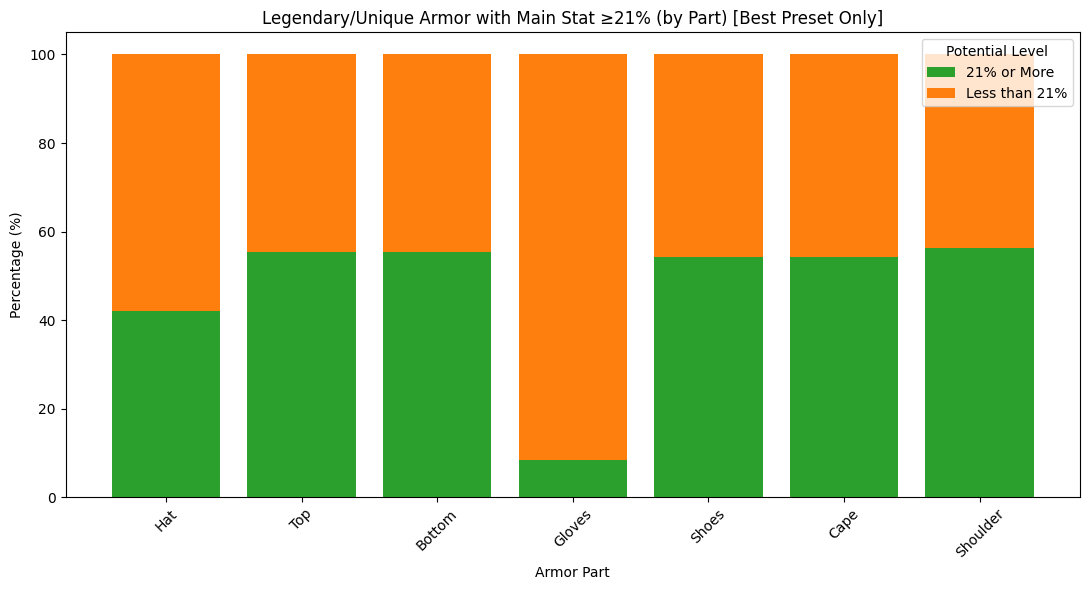

In [ ]:
# 잠재능력이 레전드리 or 유니크 등급인 방어구 중 방어구에 '주스탯' 옵션이 있다면, 21% 이상으로 사용하는 유저들이 많을까?

# 방어구 부위: 한글 → 영어 맵핑
armor_name_map = {
    "모자": "Hat",
    "상의": "Top",
    "하의": "Bottom",
    "장갑": "Gloves",
    "신발": "Shoes",
    "망토": "Cape",
    "어깨장식": "Shoulder"
}
armor_parts = list(armor_name_map.keys())

# 직업별 주스탯 맵핑
main_stat_map = {
    "STR": ["아델", "소울마스터", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

def get_main_stat(row):
    job = row["job"]
    for stat, jobs in main_stat_map.items():
        if job in jobs:
            return stat
    return None

def extract_percent(option, stat):
    if pd.isna(option): return 0
    key = f"{stat} : +"
    if key in option and "%" in option:
        try:
            return int(option.split(key)[-1].replace("%", ""))
        except:
            return 0
    return 0

def calc_main_stat_percent(row):
    stat = row["main_stat_type"]
    if not stat or stat == "HP": return None
    total = sum(extract_percent(row[col], stat) for col in ["potential_option_1", "potential_option_2", "potential_option_3"])
    return total if total > 0 else None

# 필터링: 방어구 & 레전드리 or 유니크
filtered = item_df_best[
    (item_df_best["equipment_part"].isin(armor_parts)) &
    (item_df_best["potential_option_grade"].isin(["레전드리", "유니크"]))
].copy()

filtered["main_stat_type"] = filtered.apply(get_main_stat, axis=1)
filtered["main_stat_percent"] = filtered.apply(calc_main_stat_percent, axis=1)
filtered = filtered[filtered["main_stat_percent"].notnull()].copy()
filtered["over_21"] = filtered["main_stat_percent"] >= 21
filtered["equipment_part_eng"] = filtered["equipment_part"].map(armor_name_map)

# 그룹화 및 비율 계산
grouped = filtered.groupby(["equipment_part_eng", "over_21"]).size().unstack().fillna(0)
percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex([armor_name_map[k] for k in armor_parts])  # 순서 고정

# 시각화
plt.figure(figsize=(11, 6))
colors = {True: "#2ca02c", False: "#ff7f0e"}
bottom = None

for label in [True, False]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="21% or More" if label else "Less than 21%",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Legendary/Unique Armor with Main Stat ≥21% (by Part) [Best Preset Only]")
plt.ylabel("Percentage (%)")
plt.xlabel("Armor Part")
plt.xticks(rotation=45)
plt.legend(title="Potential Level")
plt.tight_layout()
plt.show()

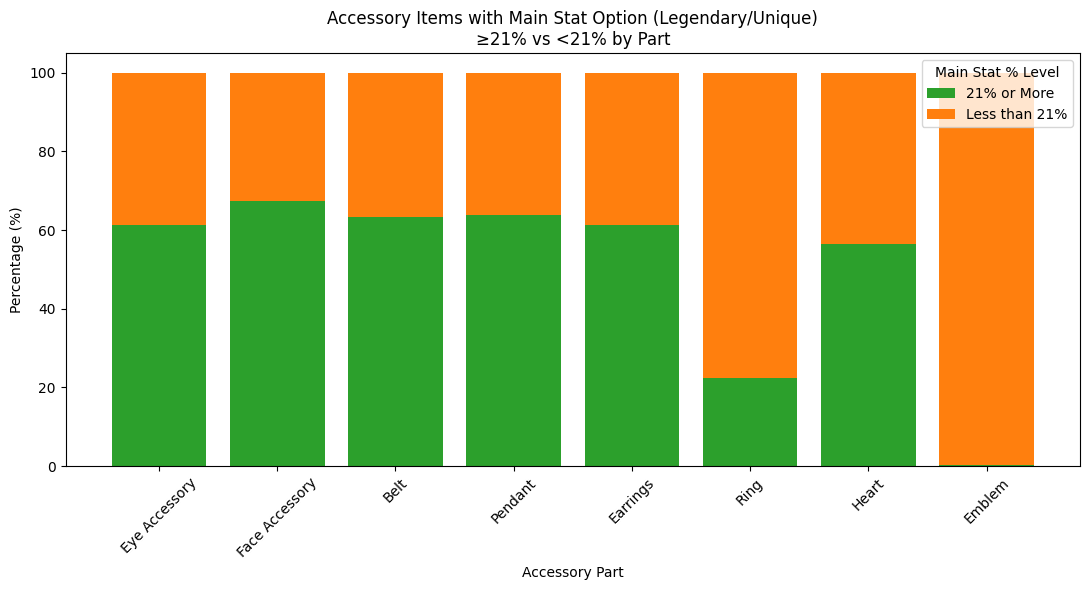

In [ ]:
# 잠재능력이 레전드리 or 유니크 등급인 장신구 중 장신구에 '주스탯' 옵션이 있다면, 21% 이상으로 사용하는 유저들이 많을까?

# 장신구 맵핑
accessory_name_map = {
    "눈장식": "Eye Accessory",
    "얼굴장식": "Face Accessory",
    "벨트": "Belt",
    "펜던트": "Pendant",
    "귀고리": "Earrings",
    "반지": "Ring",
    "기계 심장": "Heart",
    "엠블렘": "Emblem"
}
accessory_parts = list(accessory_name_map.keys())

main_stat_map = {
    "STR": ["아델", "소울마스터", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

def extract_percent(option, stat):
    if pd.isna(option): return 0
    key = f"{stat} : +"
    if key in option and "%" in option:
        try:
            return int(option.split(key)[-1].replace("%", ""))
        except:
            return 0
    return 0

def calc_main_stat_percent(row):
    stat = row["main_stat_type"]
    if not stat or stat == "HP": return None
    total = sum(extract_percent(row[col], stat) for col in ["potential_option_1", "potential_option_2", "potential_option_3"])
    return total if total > 0 else None

# 특수 능력 반지 목록
special_rings = [
    "리스트레인트 링", "리스크테이커 링", "크라이시스-HM링", "컨티뉴어스 링",
    "웨폰퍼프-S링", "웨폰퍼프-D링", "웨폰퍼프-I링", "웨폰퍼프-L링",
    "레벨퍼프-S링", "레벨퍼프-D링", "레벨퍼프-I링", "레벨퍼프-L링",
    "링 오브 썸", "듀라빌리티 링",
    "얼티메이덤 링", "크리데미지 링", "크라이시스-H링", "크라이시스-M링",
    "크리디펜스 링", "스위프트 링", "헬스컷 링", "마나컷 링", "리밋 링",
    "실드스와프 링", "크리쉬프트 링", "스탠스쉬프트 링",
    "타워인헨스 링", "오버패스 링", "리플렉티브 링",
    "버든리프트 링", "리커버디펜스 링", "리커버스탠스 링"
]

# 필터링
filtered = item_df_best[
    (item_df_best["equipment_part"].isin(accessory_parts)) &
    (item_df_best["potential_option_grade"].isin(["레전드리", "유니크"])) &
    ~((item_df_best["equipment_part"] == "반지") & (item_df_best["item_name"].isin(special_rings)))
].copy()

filtered["main_stat_type"] = filtered.apply(get_main_stat, axis=1)
filtered["main_stat_percent"] = filtered.apply(calc_main_stat_percent, axis=1)
filtered = filtered[filtered["main_stat_percent"].notnull()].copy()
filtered["over_21"] = filtered["main_stat_percent"] >= 21
filtered["equipment_part_eng"] = filtered["equipment_part"].map(accessory_name_map)

# 비율 집계
grouped = filtered.groupby(["equipment_part_eng", "over_21"]).size().unstack().fillna(0)
percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex([accessory_name_map[k] for k in accessory_parts])

# 시각화
colors = {True: "#2ca02c", False: "#ff7f0e"}
bottom = None

plt.figure(figsize=(11, 6))
for label in [True, False]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="21% or More" if label else "Less than 21%",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Accessory Items with Main Stat Option (Legendary/Unique)\n≥21% vs <21% by Part")
plt.ylabel("Percentage (%)")
plt.xlabel("Accessory Part")
plt.xticks(rotation=45)
plt.legend(title="Main Stat % Level")
plt.tight_layout()
plt.show()

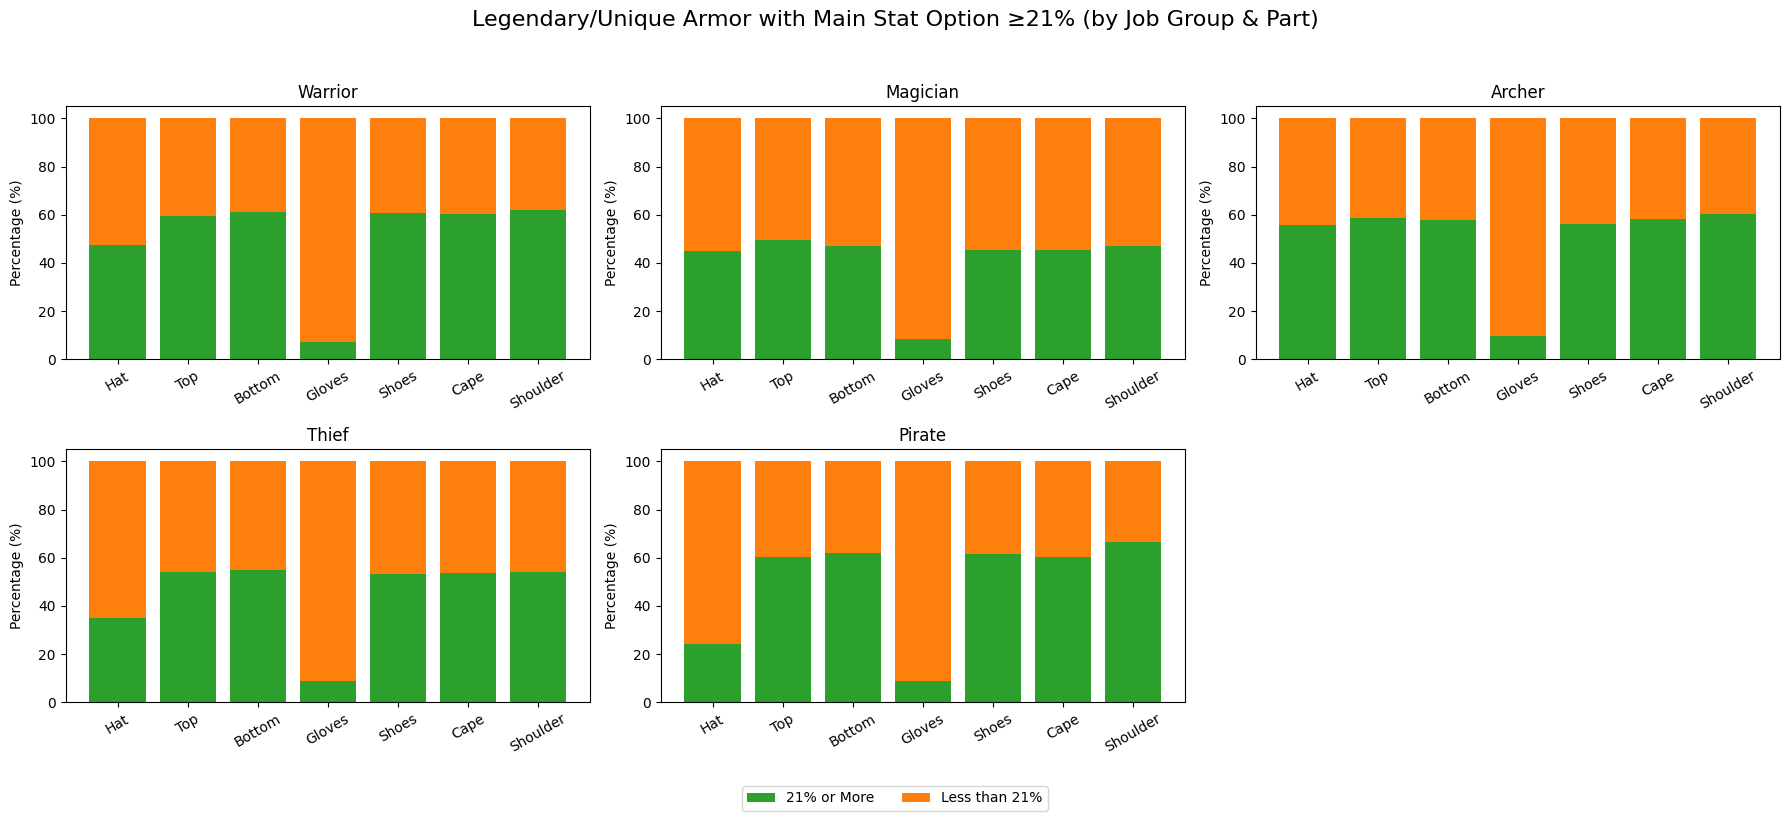

In [ ]:
# 직업군별 추세 확인(방어구 잠재옵션 중 주스탯이 달려있다면, 21% 이상의 수치를 사용하고 있을 것인지?)
df = item_df_best.copy()

# 방어구 한글 → 영어 매핑
armor_name_map = {
    "모자": "Hat",
    "상의": "Top",
    "하의": "Bottom",
    "장갑": "Gloves",
    "신발": "Shoes",
    "망토": "Cape",
    "어깨장식": "Shoulder"
}
armor_parts = list(armor_name_map.keys())

# 직업군 한글 → 영어 매핑
job_group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
job_group_order = ["Warrior", "Magician", "Archer", "Thief", "Pirate"]

# 직업별 주스탯 매핑
main_stat_map = {
    "STR": ["아델", "소울마스터", "아란", "히어로", "제로", "팔라딘", "다크나이트", "카이저",
            "데몬슬레이어", "미하일", "블래스터", "은월", "바이퍼", "스트라이커", "캐논마스터"],
    "DEX": ["윈드브레이커", "메르세데스", "보우마스터", "패스파인더", "신궁", "카인", "와일드헌터",
            "엔젤릭버스터", "캡틴", "메카닉"],
    "INT": ["비숍", "아크메이지(불,독)", "아크메이지(썬,콜)", "라라", "배틀메이지", "에반", "루미너스",
            "키네시스", "플레임위자드", "일리움"],
    "LUK": ["나이트워커", "섀도어", "나이트로드", "듀얼블레이더", "팬텀", "호영", "칼리", "카데나"],
    "HP": ["데몬어벤져"],
    "ALL": ["제논"]
}

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

def extract_percent(option, stat):
    if pd.isna(option): return 0
    key = f"{stat} : +"
    if key in option and "%" in option:
        try:
            return int(option.split(key)[-1].replace("%", ""))
        except:
            return 0
    return 0

def calc_main_stat_percent(row):
    stat = row["main_stat_type"]
    if not stat or stat == "HP":
        return None
    total = sum(extract_percent(row[col], stat) for col in ["potential_option_1", "potential_option_2", "potential_option_3"])
    return total if total > 0 else None

# 필터링 및 전처리
df = df[(df["equipment_part"].isin(armor_parts)) & (df["potential_option_grade"].isin(["레전드리", "유니크"]))].copy()
df["main_stat_type"] = df.apply(get_main_stat, axis=1)
df["main_stat_percent"] = df.apply(calc_main_stat_percent, axis=1)
df = df[df["main_stat_percent"].notnull()].copy()
df["over_21"] = df["main_stat_percent"] >= 21
df["equipment_part_eng"] = df["equipment_part"].map(armor_name_map)
df["job_group_eng"] = df["job_group"].map(job_group_map)

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for idx, group in enumerate(job_group_order):
    ax = axes[idx]
    subset = df[df["job_group_eng"] == group]
    grouped = subset.groupby(["equipment_part_eng", "over_21"]).size().unstack().fillna(0)
    percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100
    percent_df = percent_df.reindex([armor_name_map[k] for k in armor_parts])

    bottom = None
    for label in [True, False]:
        ax.bar(
            percent_df.index,
            percent_df[label],
            bottom=bottom,
            label="21% or More" if label else "Less than 21%",
            color="#2ca02c" if label else "#ff7f0e"
        )
        bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

    ax.set_title(group)
    ax.set_xticks(range(len(percent_df.index)))
    ax.set_xticklabels(list(percent_df.index), rotation=30)
    # ax.set_xticklabels(percent_df.index, rotation=30)
    ax.set_ylabel("Percentage (%)")

for j in range(len(job_group_order), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Legendary/Unique Armor with Main Stat Option ≥21% (by Job Group & Part)", fontsize=16)
fig.legend(["21% or More", "Less than 21%"], loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.03))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

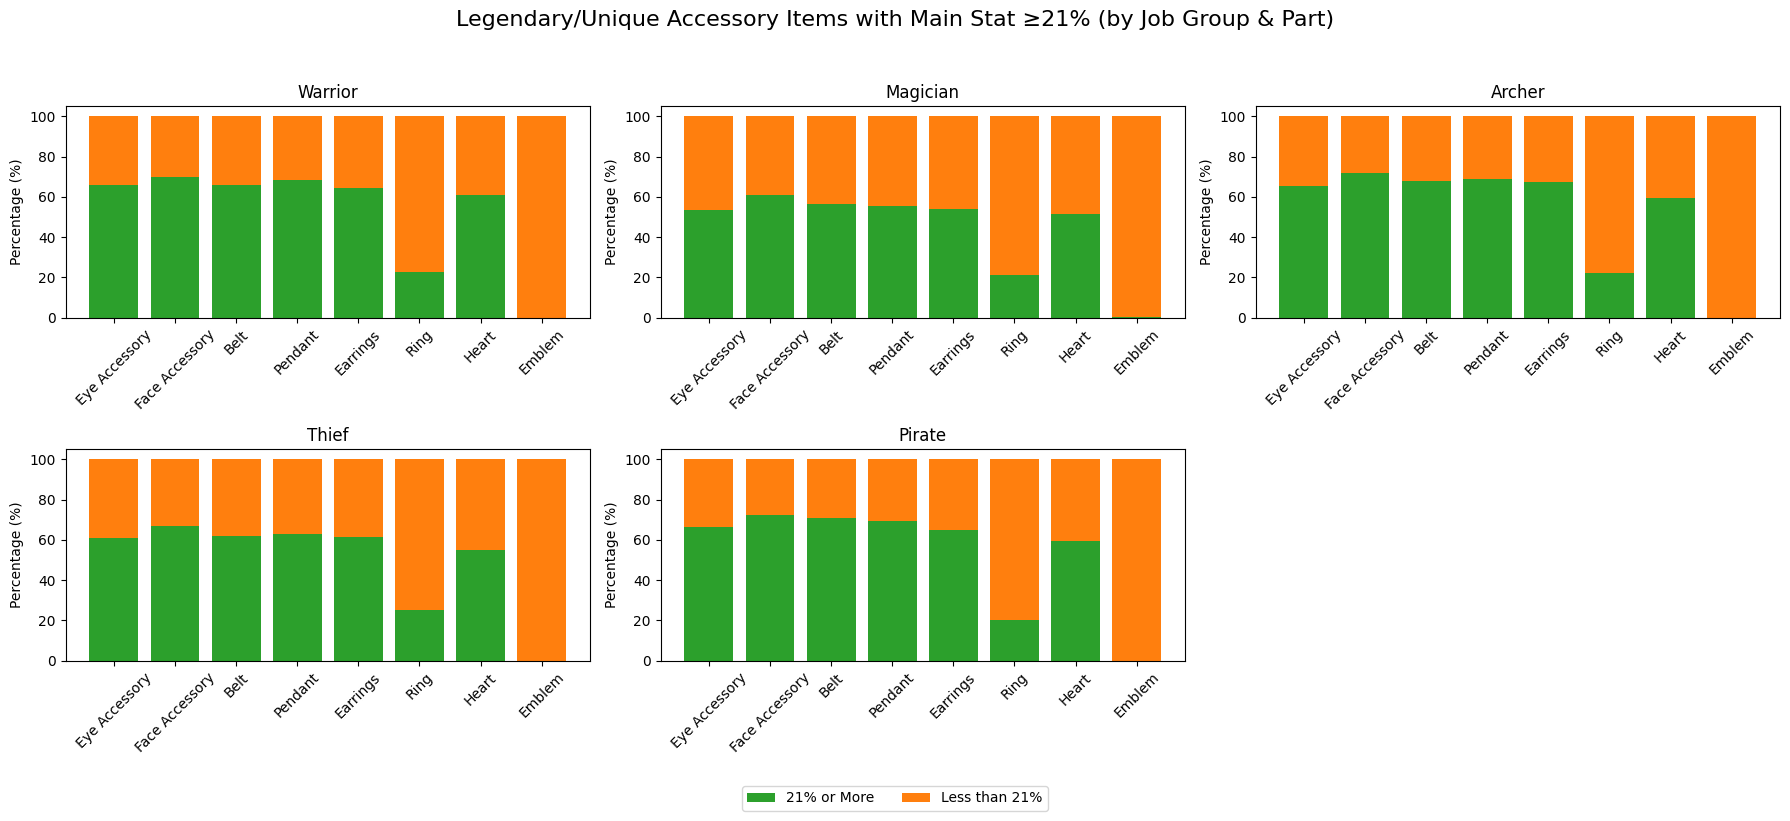

In [ ]:
# 직업군별 추세 확인(장신구 잠재옵션 중 주스탯이 달려있다면, 21% 이상의 수치를 사용하고 있을 것인지?)

# 특수 능력 반지 목록
special_rings = [
    "리스트레인트 링", "리스크테이커 링", "크라이시스-HM링", "컨티뉴어스 링",
    "웨폰퍼프-S링", "웨폰퍼프-D링", "웨폰퍼프-I링", "웨폰퍼프-L링",
    "레벨퍼프-S링", "레벨퍼프-D링", "레벨퍼프-I링", "레벨퍼프-L링",
    "링 오브 썸", "듀라빌리티 링",
    "얼티메이덤 링", "크리데미지 링", "크라이시스-H링", "크라이시스-M링",
    "크리디펜스 링", "스위프트 링", "헬스컷 링", "마나컷 링", "리밋 링",
    "실드스와프 링", "크리쉬프트 링", "스탠스쉬프트 링",
    "타워인헨스 링", "오버패스 링", "리플렉티브 링",
    "버든리프트 링", "리커버디펜스 링", "리커버스탠스 링"
]

# 필터링: 레전드리/유니크 + 장신구 + 특수 반지 제외
df = item_df_best[
    (item_df_best["equipment_part"].isin(accessory_parts)) &
    (item_df_best["potential_option_grade"].isin(["레전드리", "유니크"])) &
    ~((item_df_best["equipment_part"] == "반지") & (item_df_best["item_name"].isin(special_rings)))
].copy()

# 주스탯 매핑
def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

df["main_stat_type"] = df.apply(get_main_stat, axis=1)

# 주스탯 퍼센트 계산
def extract_percent(option, stat):
    if pd.isna(option): return 0
    key = f"{stat} : +"
    if key in option and "%" in option:
        try:
            return int(option.split(key)[-1].replace("%", ""))
        except:
            return 0
    return 0

def calc_main_stat_percent(row):
    stat = row["main_stat_type"]
    if not stat or stat == "HP":
        return None
    total = sum(extract_percent(row[col], stat) for col in ["potential_option_1", "potential_option_2", "potential_option_3"])
    return total if total > 0 else None

df["main_stat_percent"] = df.apply(calc_main_stat_percent, axis=1)
df = df[df["main_stat_percent"].notnull()].copy()

# 기준 이상 여부 및 영어 매핑
df["over_21"] = df["main_stat_percent"] >= 21
df["equipment_part_eng"] = df["equipment_part"].map(accessory_name_map)
df["job_group_eng"] = df["job_group"].map(job_group_map)

# 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 8))
axes = axes.flatten()

for idx, group in enumerate(job_group_order):
    ax = axes[idx]
    subset = df[df["job_group_eng"] == group]
    grouped = subset.groupby(["equipment_part_eng", "over_21"]).size().unstack().fillna(0)
    percent_df = grouped.div(grouped.sum(axis=1), axis=0) * 100
    percent_df = percent_df.reindex([accessory_name_map[k] for k in accessory_parts])

    x_pos = range(len(percent_df.index))
    bottom = None
    for label in [True, False]:
        ax.bar(
            x_pos,
            percent_df[label],
            bottom=bottom,
            label="21% or More" if label else "Less than 21%",
            color="#2ca02c" if label else "#ff7f0e"
        )
        bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

    ax.set_xticks(x_pos)
    ax.set_xticklabels(percent_df.index, rotation=45)
    ax.set_title(group)
    ax.set_ylabel("Percentage (%)")

for j in range(len(job_group_order), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Legendary/Unique Accessory Items with Main Stat ≥21% (by Job Group & Part)", fontsize=16)
fig.legend(["21% or More", "Less than 21%"], loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.03))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

시각화 결과: 잠재능력의 경우, 아이템 종류별로 '주스탯' 옵션 사용 여부가 크게 차이난다. 모든 아이템에서 주스탯 21% 이상의 옵션을 사용하는 유저들이 많지는 않다. **(기존 가설 = FALSE)**
- 주스탯 옵션을 사용하는 경우, 방어구는 **상의, 하의, 신발, 망토, 어깨장식**에서 21% 이상의 옵션을 많이 사용한다.
- 장신구는 **반지와 엠블렘을 제외하고** 21% 이상의 옵션을 많이 사용한다.
----
- 또한 이를 직업군별로 살펴보았을 때, 공통적으로 방어구 중 장갑은 주스탯 옵션을 사용하지 않을 확률이 높았다.
- 공통적으로 장신구 중 엠블렘 역시 주스탯 옵션을 사용하지 않을 확률이 높았다.

### 추론 통계

In [ ]:
# 방어구에 주스탯 21% 이상 옵션을 사용하는 유저는 전체적으로 적다?: 카이제곱 적합도 검정

# 전체 집계
obs_counts = legend_unique_df["over_21"].value_counts().reindex([True, False], fill_value=0)
observed = obs_counts.values  # [21% 이상 사용 수, 미사용 수]

# 기대 분포: 균등
expected = [sum(observed) / 2] * 2

# 검정
chi2, pval = chisquare(f_obs=observed, f_exp=expected)

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print("Observed counts:", dict(zip(["21% 이상", "21% 미만"], observed)))

Chi-square: 146264.476, p-value: 0.0000
Observed counts: {'21% 이상': np.int64(41676), '21% 미만': np.int64(247246)}


- 귀무가설 (H₀): 방어구에 주스탯 21% 이상 옵션을 사용하는 유저와 그렇지 않은 유저의 비율은 동일하다.
- 대립가설 (H₁): 방어구에 주스탯 21% 이상 옵션을 사용하는 유저의 비율은 50%보다 유의미하게 적다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 방어구에 주스탯 21% 이상 옵션을 사용하는 유저가 통계적으로 유의미하게 적다고 할 수 있다.**

In [ ]:
# 장신구에 주스탯 21% 이상 옵션을 사용하는 유저는 전체적으로 적다?: 카이제곱 적합도 검정

# 카운트 정리
obs_counts = legend_acc_df["over_21"].value_counts().reindex([True, False], fill_value=0)
observed = obs_counts.values  # [21% 이상, 21% 미만]

# 기대값: 균등 (50:50)
expected = [sum(observed) / 2] * 2

# 카이제곱 적합도 검정
chi2, pval = chisquare(f_obs=observed, f_exp=expected)

# 결과 출력
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print("Observed counts:", dict(zip(["21% 이상", "21% 미만"], observed)))

Chi-square: 143945.659, p-value: 0.0000
Observed counts: {'21% 이상': np.int64(48368), '21% 미만': np.int64(258561)}


- 귀무가설 (H₀): 장신구에 주스탯 21% 이상 옵션을 사용하는 유저와 그렇지 않은 유저의 비율은 동일하다.
- 대립가설 (H₁): 장신구에 주스탯 21% 이상 옵션을 사용하는 유저의 비율은 50%보다 유의미하게 적다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 장신구에 주스탯 21% 이상 옵션을 사용하는 유저가 통계적으로 유의미하게 적다고 할 수 있다.**
  - χ² = 143,945.659 → 매우 크다! → 실제 관측값과 50:50 기대값의 차이가 극심하게 크다는 뜻 → “장신구에 21% 이상 옵션을 넣는 건 정말 드문 일이다”는 결론을 내릴 수 있음

In [ ]:
# 방어구 잠재능력에 주스탯이 달려있다면 21% 이상일까?: 카이제곱 적합도 검정

# 카운트 추출
obs_counts = filtered["over_21"].value_counts().reindex([True, False], fill_value=0)
observed = obs_counts.values  # [21% 이상, 21% 미만]

# 기대 분포: 50:50
expected = [sum(observed) / 2] * 2

# 카이제곱 적합도 검정
chi2, pval = chisquare(f_obs=observed, f_exp=expected)

# 결과 출력
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print("Observed counts:", dict(zip(["21% 이상", "21% 미만"], observed)))

Chi-square: 2594.434, p-value: 0.0000
Observed counts: {'21% 이상': np.int64(48368), '21% 미만': np.int64(33770)}


- 귀무가설 (H₀): 방어구에 주스탯이 있는 경우, 21% 이상과 미만의 비율은 같을 것이다.
- 대립가설 (H₁): 방어구에 주스탯이 있는 경우, 21% 이상 사용 비율은 50%보다 유의미하게 다르다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 방어구에 주스탯이 있는 경우, 21% 이상을 사용하는 유저가 유의미하게 더 많다고 할 수 있다.**
  - 그러나 앞선 분석 결과와 함께 정리하자면 유저들은 방어구 잠재능력에서 주스탯을 잘 사용하지 않는 것 같지만, 일단 주스탯이 붙어 있으면 21% 이상으로 세팅하는 경향이 강하다고 할 수 있다.

In [ ]:
# 장신구 잠재능력에 주스탯이 달려있다면 21% 이상일까?: 카이제곱 적합도 검정

# 카운트
obs_counts = filtered["over_21"].value_counts().reindex([True, False], fill_value=0)
observed = obs_counts.values  # [21% 이상, 21% 미만]

# 기대값: 균등(50:50)
expected = [sum(observed) / 2] * 2

# 검정 실행
chi2, pval = chisquare(f_obs=observed, f_exp=expected)

# 결과 출력
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print("Observed counts:", dict(zip(["21% 이상", "21% 미만"], observed)))

Chi-square: 2594.434, p-value: 0.0000
Observed counts: {'21% 이상': np.int64(48368), '21% 미만': np.int64(33770)}


- 귀무가설 (H₀): 장신구에 주스탯이 있는 경우, 21% 이상과 미만의 비율은 같을 것이다.
- 대립가설 (H₁): 장신구에 주스탯이 있는 경우, 21% 이상 사용 비율은 50%보다 유의미하게 다르다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 장신구에 주스탯이 있는 경우, 21% 이상을 사용하는 유저가 유의미하게 더 많다고 할 수 있다.**
  - 그러나 앞선 방어구 분석 패턴과 비슷하게, 유저들은 장신구 잠재능력에서 주스탯을 잘 사용하지 않는 것 같지만, 일단 주스탯이 붙어 있으면 21% 이상으로 세팅하는 경향이 강하다고 할 수 있다.

In [ ]:
# 직업군에 따라 방어구 주스탯 21% 이상 옵션 사용 경향이 다른지 두 범주형 변수 간의 독립성 검정: 카이제곱 독립성 검정

# 교차표 생성
crosstab = pd.crosstab(df["job_group_eng"], df["over_21"])

# 카이제곱 독립성 검정
chi2, pval, dof, expected = chi2_contingency(crosstab)

# Cramér's V 계산
n = crosstab.to_numpy().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 출력
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cramér’s V: {cramers_v:.4f}")

Chi-square: 749.343, p-value: 0.0000
Cramér’s V: 0.0955


- 귀무가설(H₀): 직업군과 방어구의 21% 이상 잠재능력 사용 여부는 서로 독립이다. (직업군에 상관없이 21% 이상 사용 비율이 비슷하다.)
- 대립가설(H₁): 직업군과 방어구의 21% 이상 잠재능력 사용 여부는 서로 독립이 아니다. (직업군에 따라 사용 경향이 다르다.)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 방어구에 21% 이상 옵션을 얼마나 사용하는지 통계적으로 유의미한 차이가 있다고 할 수 있다.**
  - 다만, **Cramér’s V = 0.0955** 수준으로 관련성은 **매우 약한 수준**이었으며,
이는 **직업군이 방어구 세팅 방식에 큰 영향을 미치지는 않으며, 대부분의 유저는 직업군에 관계없이 비슷한 경향을 보인다는 점**을 시사한다.

In [ ]:
# 직업군에 따라 장신구 주스탯 21% 이상 옵션 사용 경향이 다른지 두 범주형 변수 간의 독립성 검정: 카이제곱 독립성 검정

# 교차표 생성
crosstab = pd.crosstab(df["job_group_eng"], df["over_21"])

# 카이제곱 독립성 검정
chi2, pval, dof, expected = chi2_contingency(crosstab)

# Cramér's V 계산
n = crosstab.to_numpy().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 결과 출력
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cramér’s V: {cramers_v:.4f}")

Chi-square: 749.343, p-value: 0.0000
Cramér’s V: 0.0955


- 귀무가설(H₀): 직업군과 장신구의 21% 이상 잠재능력 사용 여부는 서로 독립이다. (직업군에 상관없이 21% 이상 사용 비율이 비슷하다.)
- 대립가설(H₁): 직업군과 장신구의 21% 이상 잠재능력 사용 여부는 서로 독립이 아니다. (직업군에 따라 사용 경향이 다르다.)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 장신구에 21% 이상 옵션을 얼마나 사용하는지 통계적으로 유의미한 차이가 있다고 할 수 있다.**
  - 다만, **Cramér’s V = 0.0955**로 관련성은 **매우 약한 수준**에 불과하며,
실질적으로는 **직업군과 무관하게 유사한 세팅 전략이 대부분의 유저에게서 관찰된다.**

### **최종 정리**
----
대부분의 유저는 **방어구나 장신구에서 주스탯 21% 이상을 잘 사용하지 않지만,
주스탯이 붙은 경우에는 고수치(21% 이상)로 세팅하는 경향이 뚜렷**하다.

직업군에 따른 차이는 **통계적으로는 유의하나, 실질적 영향력은 거의 없으며**,
유저들은 **직업군에 관계없이 유사하게 주스탯 21% 이상을 잘 사용하지 않는 잠재능력 세팅 전략**을 따르고 있다.

## 가설 8
----
에디셔널 잠재능력의 경우, 한 유저의 아이템 세팅을 보았을 때 레전드리 등급보다 그 아래 등급을 사용하고 있는 경우가 더 많을 것이다.

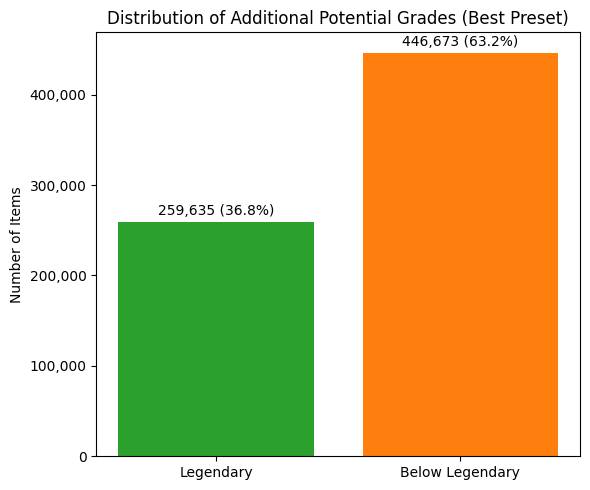

In [ ]:
# 에디셔널 잠재능력 등급 개수 집계
grade_counts = (
    item_df_best["additional_potential_option_grade"]
    .value_counts()
    .to_dict()
)

# 레전드리 vs 그 이하 등급 구분
legend_count = grade_counts.get("레전드리", 0)
total_count = sum(grade_counts.values())
non_legend_count = total_count - legend_count

# 데이터 준비
labels = ["Legendary", "Below Legendary"]
counts = [legend_count, non_legend_count]

# 시각화
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, counts, color=["#2ca02c", "#ff7f0e"])

# Y축 숫자 포맷: 쉼표 포함
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x):,}"))

plt.title("Distribution of Additional Potential Grades (Best Preset)")
plt.ylabel("Number of Items")

# 막대 위 수치 + 비율 표시
for bar, count in zip(bars, counts):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + total_count * 0.005,  # 간격 조정
        f"{count:,} ({count / total_count:.1%})",
        ha="center", va="bottom", fontsize=10
    )

plt.tight_layout()
plt.show()

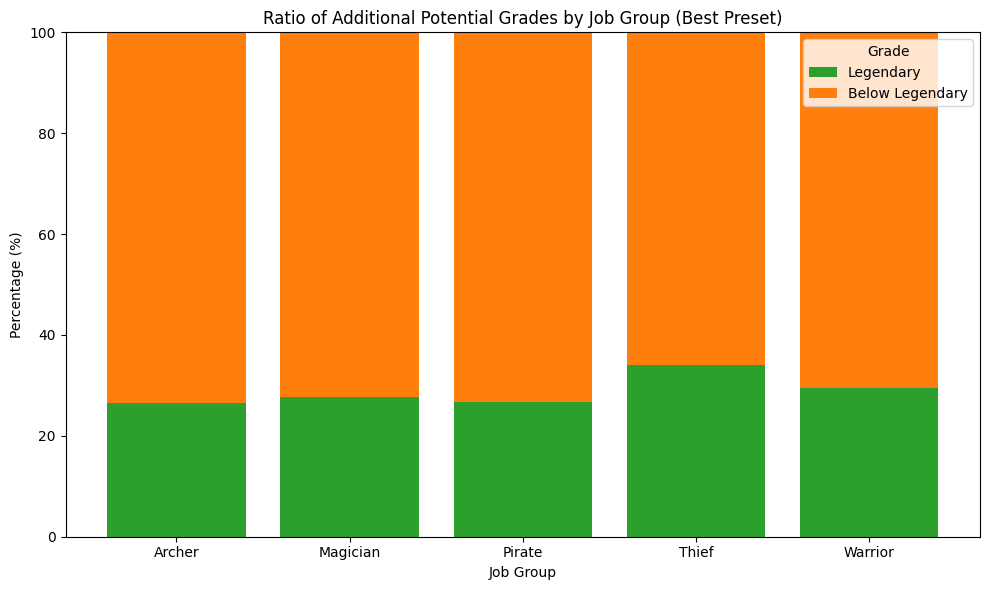

In [ ]:
# 직업군별로 살펴보기

# 직업군 매핑
job_group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(job_group_map)

# 등급 그룹화
def classify_additional_grade(grade):
    return "Legendary" if grade == "레전드리" else "Below Legendary"

item_df_best["additional_grade_group"] = item_df_best["additional_potential_option_grade"].apply(classify_additional_grade)

# 집계 → 비율
pivot_df = (
    item_df_best.groupby(["job_group_eng", "additional_grade_group"])
    .size()
    .unstack()
    .fillna(0)
)

percent_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100
percent_df = percent_df[["Legendary", "Below Legendary"]]  # 순서 고정

# 시각화
colors = {"Legendary": "#2ca02c", "Below Legendary": "#ff7f0e"}
plt.figure(figsize=(10, 6))
bottom = None

for label in percent_df.columns:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label=label,
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Ratio of Additional Potential Grades by Job Group (Best Preset)")
plt.ylabel("Percentage (%)")
plt.xlabel("Job Group")
plt.legend(title="Grade")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

시각화 결과: 에디셔널 잠재능력의 경우, 레전드리 등급보다 그 아래 등급을 사용하고 있는 경우가 더 많았다. **(기존 가설= TRUE)**
  - 또한 모든 직업군에서 같은 경향성이 나타났다.

### 추론 통계

In [ ]:
# 전체 유저 기준: 카이제곱 적합도 검정

# 관측값
observed = [legend_count, non_legend_count]
expected = [sum(observed)/2, sum(observed)/2]  # 50:50 기대

# 카이제곱 적합도 검정
chi2, pval = chisquare(f_obs=observed, f_exp=expected)

# 출력
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print("Observed:", {"Legendary": legend_count, "Below Legendary": non_legend_count})

Chi-square: 49529.686, p-value: 0.0000
Observed: {'Legendary': 259635, 'Below Legendary': 446673}


- 귀무가설(H₀): 에디셔널 잠재능력의 경우, 레전드리와 비레전드리 사용 비율은 동일하다.
- 대립가설(H₁): 에디셔널 잠재능력의 경우, 비레전드리 사용 비율이 50%보다 유의미하게 높다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 에디셔널 잠재능력의 비레전드리 사용 비율이 50%보다 유의미하게 높다고 할 수 있다.**

In [ ]:
# 직업군별 비교: 카이제곱 독립성 검정

# 교차표
crosstab = pd.crosstab(item_df_best["job_group_eng"], item_df_best["additional_grade_group"])

# 독립성 검정
chi2, pval, dof, expected = chi2_contingency(crosstab)

# Cramér's V 계산
n = crosstab.to_numpy().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

# 출력
print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cramér’s V: {cramers_v:.4f}")

Chi-square: 3124.497, p-value: 0.0000
Cramér’s V: 0.0591


- 귀무가설(H₀): 직업군과 에디셔널 잠재능력 등급은 서로 독립이다. (직업군에 따라 등급 사용 비율 차이가 없음)
- 대립가설(H₁): 직업군과 에디셔널 잠재능력 등급은 서로 독립이 아니다. (직업군에 따라 등급 사용 비율이 다름)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 에디셔널 잠재능력 등급 사용 비율이 통계적으로 유의미하게 다름이 입증되었다고 할 수 있다.**
  - 다만, **Cramér’s V = 0.0591** 수준으로 관련성은 **매우 약한 수준**이었으며 **직업군에 따른 실질적 영향은 크지 않은 것**으로 해석할 수 있다.
즉, 유저들은 대부분 **직업군과 무관하게 에디셔널 잠재능력을 비슷한 전략으로 설정**하고 있음을 시사한다.

### **최종 정리**
----
유저들은 **에디셔널 잠재능력에서 레전드리 등급까지 올리는 경우는 상대적으로 드물며**,

이는 **직업군과 무관하게 공통적으로 나타나는 현실적인 세팅 경향**임이 통계적으로 입증되었다.

# 아이템 관련: 추가옵션

## 가설 9
----
많은 유저들이 아이템 레벨별 ‘최소 수준’에 해당하는 급 이상의 추가옵션을 사용하고 있을 것이다.

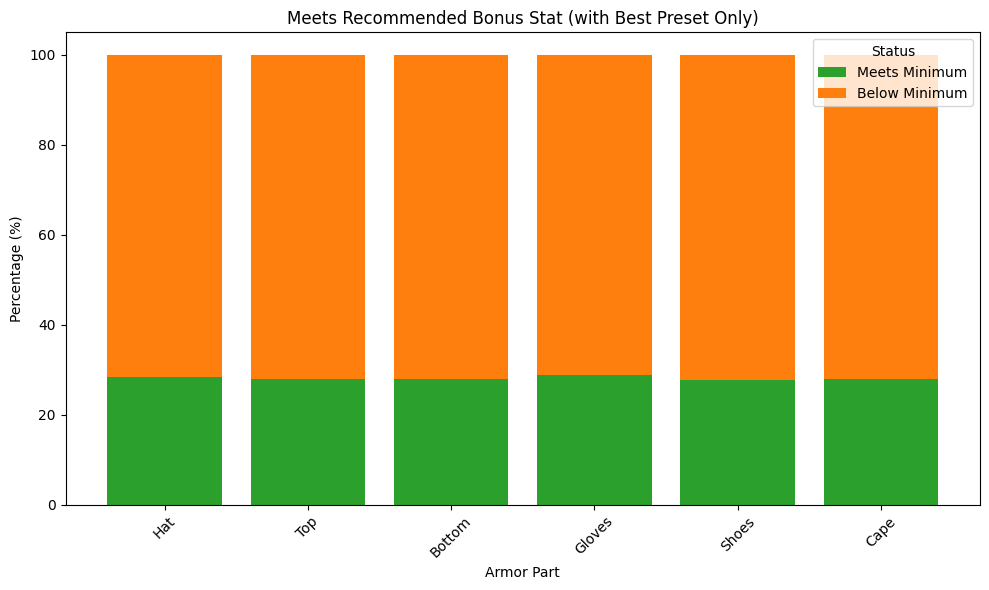

In [ ]:
# 방어구 부위별 '국민추옵' 수치 충족 여부 확인

# 방어구 부위별 맵핑
armor_name_map = {
    "모자": "Hat", "상의": "Top", "하의": "Bottom",
    "장갑": "Gloves", "신발": "Shoes", "망토": "Cape" # 어깨장식의 경우 추옵이 붙지 않아 제외
}
armor_order = ["Hat", "Top", "Bottom", "Gloves", "Shoes", "Cape"]

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df_best["main_stat_type"] = item_df_best.apply(get_main_stat, axis=1)

def get_minimum_threshold(level, stat_type):
    if stat_type == "HP":
        return level * 15
    elif stat_type == "ALL":
        if level >= 250:
            return 330
        elif level >= 200:
            return 280
        elif level >= 160:
            return 240
        elif level >= 150:
            return 230
        elif level >= 140:
            return 220
    else:
        if level >= 250:
            return 160
        elif level >= 200:
            return 140
        elif level >= 160:
            return 120
        elif level >= 140:
            return 110
    return None

def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None:
        return None
    allstat = row["all_stat_add"] * (20 if stat == "ALL" else 10)
    if stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"]
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    elif stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df_best["bonus_stat_total"] = item_df_best.apply(calculate_bonus_stat, axis=1)
item_df_best["recommended_min"] = item_df_best.apply(
    lambda row: get_minimum_threshold(row["base_equipment_level_base"], row["main_stat_type"]), axis=1
)
item_df_best["meets_minimum"] = item_df_best["bonus_stat_total"] >= item_df_best["recommended_min"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(armor_name_map)

filtered = item_df_best[item_df_best["equipment_part_eng"].isin(armor_order)]
part_group = filtered.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex(armor_order)

# 시각화
colors = {True: "#2ca02c", False: "#ff7f0e"}
bottom = None
plt.figure(figsize=(10, 6))
for label in [True, False]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="Meets Minimum" if label else "Below Minimum",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Meets Recommended Bonus Stat (with Best Preset Only)")
plt.ylabel("Percentage (%)")
plt.xlabel("Armor Part")
plt.xticks(rotation=45)
plt.legend(title="Status")
plt.tight_layout()
plt.show()

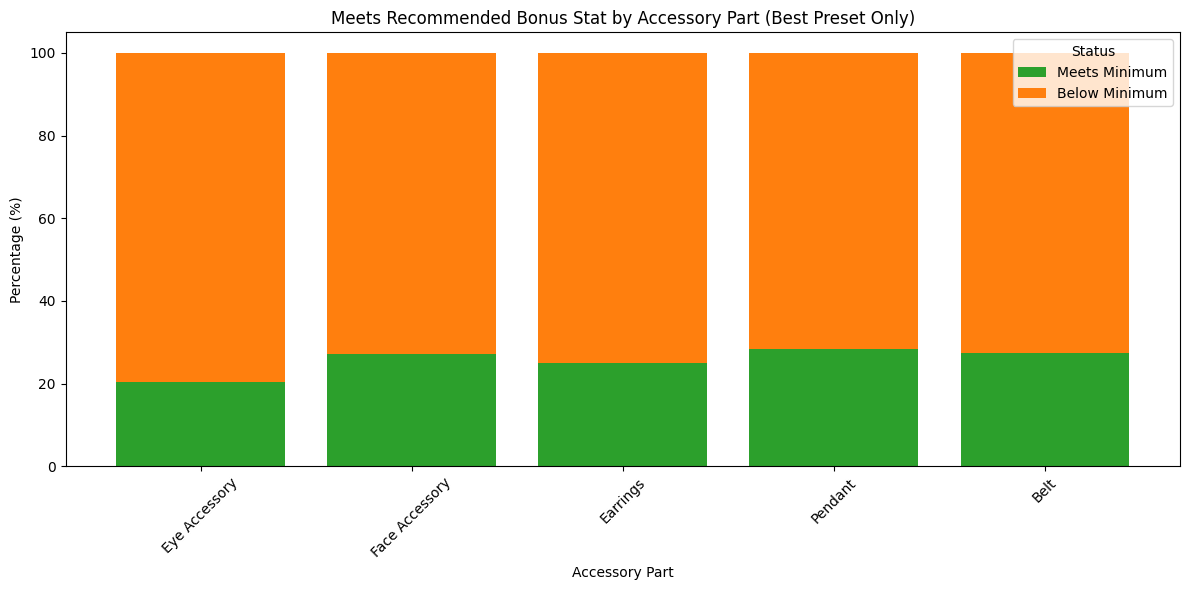

In [ ]:
# 장신구 부위별 '국민추옵' 수치 충족 여부 확인

# 장신구 이름 매핑
accessory_name_map = {
    "눈장식": "Eye Accessory", "얼굴장식": "Face Accessory", "벨트": "Belt",
    "펜던트": "Pendant", "귀고리": "Earrings"
}
accessory_order = [accessory_name_map[k] for k in ["눈장식", "얼굴장식", "귀고리", "펜던트", "벨트"]]

def get_main_stat(row):
    for stat, jobs in main_stat_map.items():
        if row["job"] in jobs:
            return stat
    return None

item_df_best["main_stat_type"] = item_df_best.apply(get_main_stat, axis=1)

def get_minimum_threshold(level, stat_type):
    if stat_type == "HP":
        return level * 15
    elif stat_type == "ALL":
        if level >= 250: return 330
        elif level >= 200: return 280
        elif level >= 160: return 240
        elif level >= 150: return 230
        elif level >= 140: return 220
    else:
        if level >= 250: return 160
        elif level >= 200: return 140
        elif level >= 160: return 120
        elif level >= 140: return 110
    return None

def calculate_bonus_stat(row):
    stat = row["main_stat_type"]
    if stat is None: return None
    allstat = row["all_stat_add"] * (20 if stat == "ALL" else 10)
    if stat == "HP":
        return row["attack_power_add"] * 150 + row["max_hp_add"] + allstat
    elif stat == "ALL":
        return row["str_add"] + row["dex_add"] + row["luk_add"] + row["attack_power_add"] * 6 + allstat
    elif stat == "INT":
        return row["int_add"] + allstat + row["magic_power_add"] * 4
    else:
        return row[f"{stat.lower()}_add"] + allstat + row["attack_power_add"] * 4

item_df_best["bonus_stat_total"] = item_df_best.apply(calculate_bonus_stat, axis=1)
item_df_best["recommended_min"] = item_df_best.apply(
    lambda row: get_minimum_threshold(row["base_equipment_level_base"], row["main_stat_type"]), axis=1
)
item_df_best["meets_minimum"] = item_df_best["bonus_stat_total"] >= item_df_best["recommended_min"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(accessory_name_map)

filtered = item_df_best[item_df_best["equipment_part_eng"].isin(accessory_order)]
part_group = filtered.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
part_group.columns = part_group.columns.astype(str)

# 누락된 열 추가 (문자열로 체크)
for col in ["True", "False"]:
    if col not in part_group.columns:
        part_group[col] = 0

# 순서 고정
part_group = part_group[["True", "False"]]

# 비율 계산
percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
percent_df = percent_df.reindex(accessory_order)

# 시각화
colors = {"True": "#2ca02c", "False": "#ff7f0e"}
bottom = None

plt.figure(figsize=(12, 6))
for label in ["True", "False"]:
    plt.bar(
        percent_df.index,
        percent_df[label],
        bottom=bottom,
        label="Meets Minimum" if label == "True" else "Below Minimum",
        color=colors[label]
    )
    bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

plt.title("Meets Recommended Bonus Stat by Accessory Part (Best Preset Only)")
plt.ylabel("Percentage (%)")
plt.xlabel("Accessory Part")
plt.xticks(rotation=45)
plt.legend(title="Status")
plt.tight_layout()
plt.show()

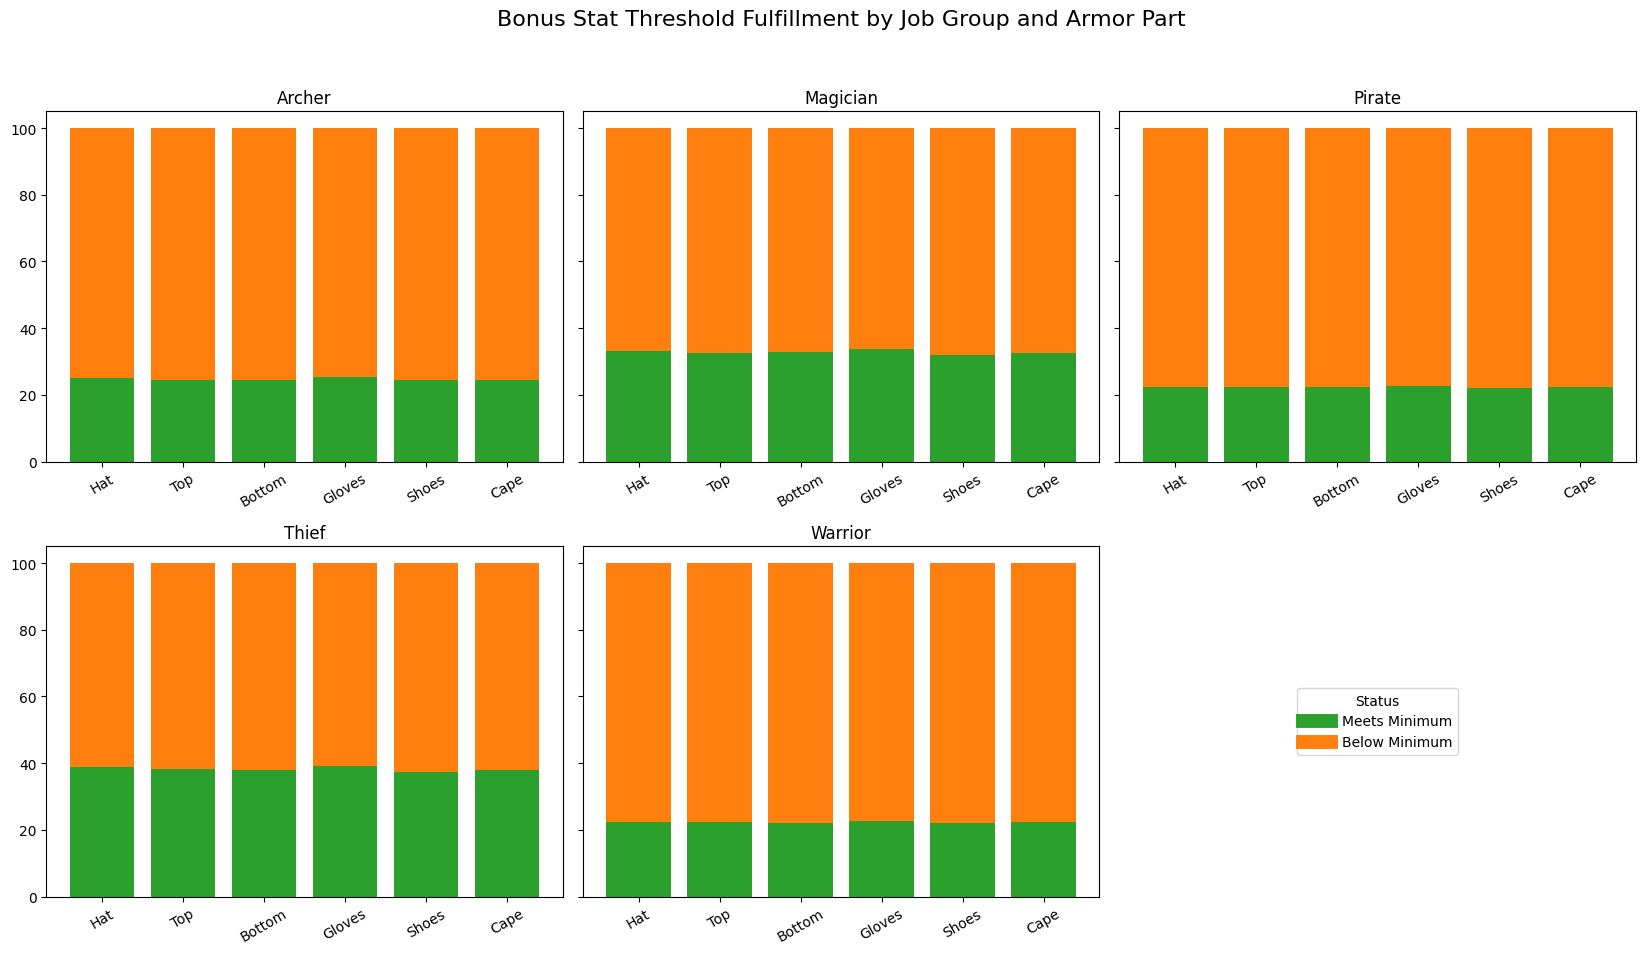

In [ ]:
# 방어구 부위별 '국민추옵' 수치 충족 여부 확인(직업군별로 살펴보기)

# 한글 문자열에 유니코드 정규화 적용
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))

# 직업군 매핑
job_group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(job_group_map)

# 방어구 부위별 맵핑
armor_name_map = {
    "모자": "Hat", "상의": "Top", "하의": "Bottom",
    "장갑": "Gloves", "신발": "Shoes", "망토": "Cape" # 어깨장식의 경우 추옵이 붙지 않아 제외
}
armor_order = ["Hat", "Top", "Bottom", "Gloves", "Shoes", "Cape"]
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(armor_name_map)

# 유효한 방어구 부위만 필터링
filtered = item_df_best[
    item_df_best["equipment_part_eng"].isin(armor_order) &
    item_df_best["job_group_eng"].notna()
]

# 직업군 리스트 생성
job_groups = sorted(filtered["job_group_eng"].unique())

# subplot 레이아웃 설정
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), sharey=True)
axes = axes.flatten()

colors = {True: "#2ca02c", False: "#ff7f0e"}

# 불필요한 subplot 인덱스 추적용
plotted_indices = []

# 직업군별 subplot 그리기
for i, group in enumerate(job_groups):
    ax = axes[i]
    plotted_indices.append(i)

    subset = filtered[filtered["job_group_eng"] == group]
    part_group = subset.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
    part_group.columns = part_group.columns.astype(bool)

    percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
    percent_df = percent_df.reindex(armor_order)

    bottom = None
    for label in [True, False]:
        ax.bar(
            percent_df.index,
            percent_df[label],
            bottom=bottom,
            label="Meets Minimum" if label else "Below Minimum",
            color=colors[label]
        )
        bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

    ax.set_title(group)
    ax.set_xticks(range(len(percent_df.index)))
    ax.set_xticklabels(percent_df.index, rotation=30)

# 빈 subplot에 범례 넣기
for j in range(len(axes)):
    if j not in plotted_indices:
        axes[j].axis("off")  # 축 꺼주고
        axes[j].legend(
            handles=[
                plt.Line2D([0], [0], color=colors[True], lw=10, label="Meets Minimum"),
                plt.Line2D([0], [0], color=colors[False], lw=10, label="Below Minimum")
            ],
            title="Status",
            loc='center'
        )

# 전체 제목 등 설정
fig.suptitle("Bonus Stat Threshold Fulfillment by Job Group and Armor Part", fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
plt.show()

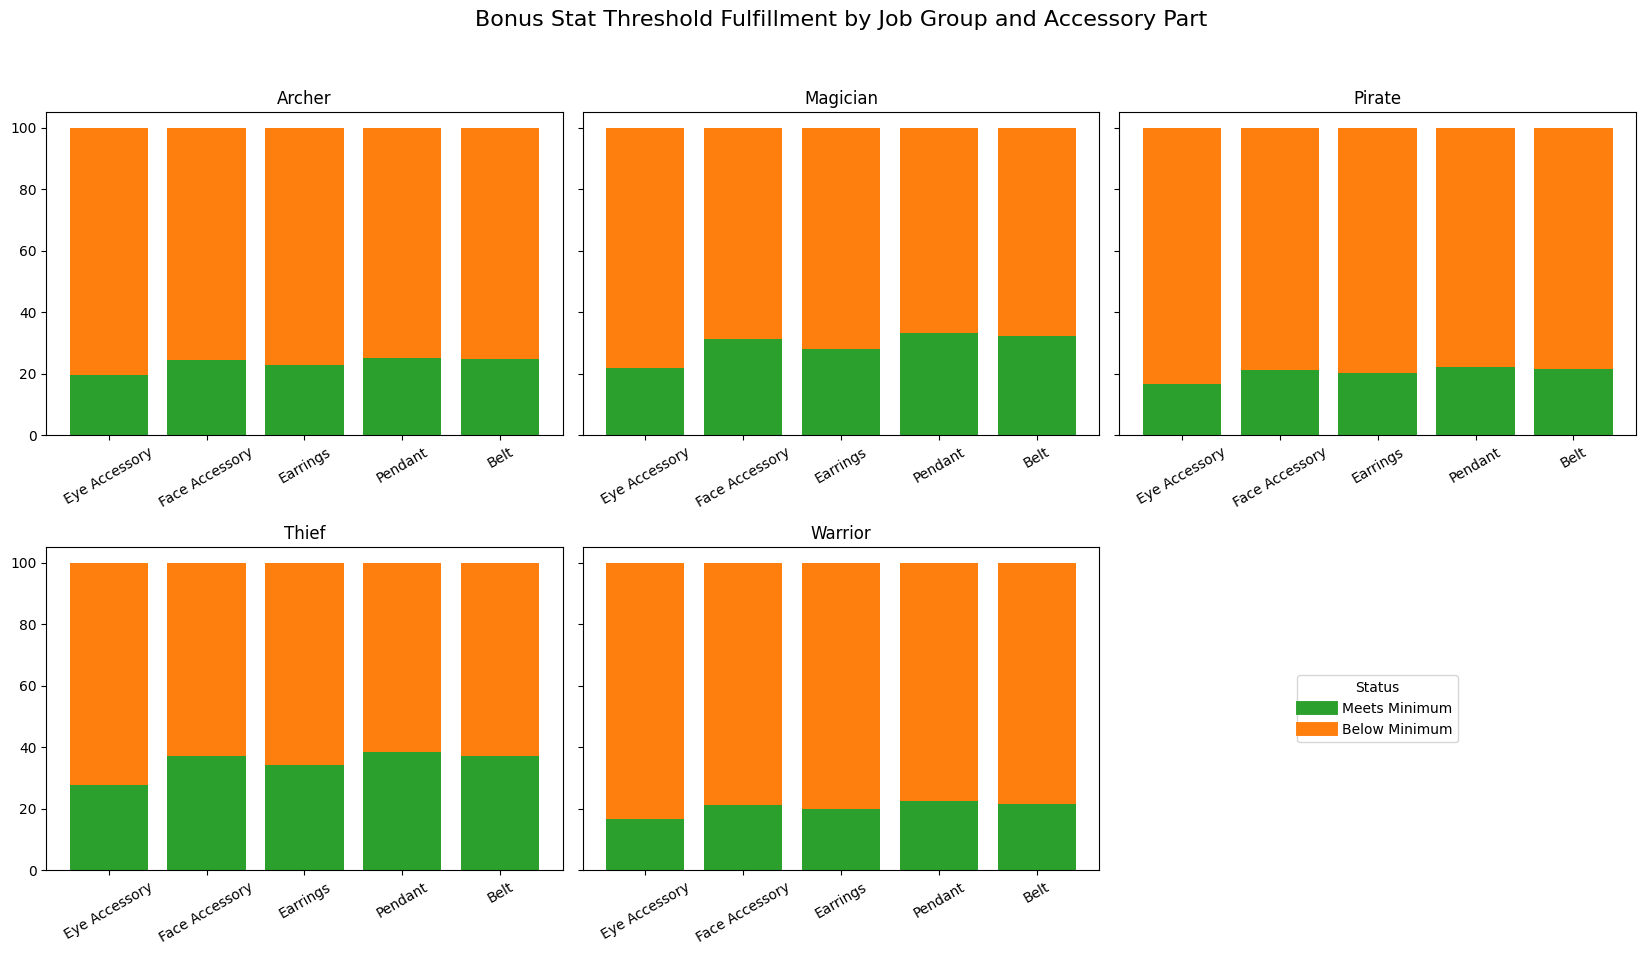

In [ ]:
# 장신구 부위별 '국민추옵' 수치 충족 여부 확인(직업군별로 살펴보기)

import unicodedata
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# 한글 문자열에 유니코드 정규화 적용
item_df_best["job_group"] = item_df_best["job_group"].apply(lambda x: unicodedata.normalize("NFC", x))

# 직업군 매핑
job_group_map = {
    "전사": "Warrior",
    "마법사": "Magician",
    "궁수": "Archer",
    "도적": "Thief",
    "해적": "Pirate"
}
item_df_best["job_group_eng"] = item_df_best["job_group"].map(job_group_map)

# 장신구 부위 이름 매핑
accessory_name_map = {
    "눈장식": "Eye Accessory",
    "얼굴장식": "Face Accessory",
    "벨트": "Belt",
    "펜던트": "Pendant",
    "귀고리": "Earrings"
}
accessory_order = [accessory_name_map[k] for k in ["눈장식", "얼굴장식", "귀고리", "펜던트", "벨트"]]

# 장신구 부위 매핑
item_df_best["equipment_part_eng"] = item_df_best["equipment_part"].map(accessory_name_map)

# 유효한 장신구 부위만 필터링
filtered = item_df_best[
    item_df_best["equipment_part_eng"].isin(accessory_order) &
    item_df_best["job_group_eng"].notna()
]

# 직업군 리스트 생성
job_groups = sorted(filtered["job_group_eng"].unique())

# subplot 레이아웃 설정
n_cols = 3
n_rows = (len(job_groups) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 10), sharey=True)
axes = axes.flatten()

colors = {True: "#2ca02c", False: "#ff7f0e"}
plotted_indices = []

# 직업군별 subplot 그리기
for i, group in enumerate(job_groups):
    ax = axes[i]
    plotted_indices.append(i)

    subset = filtered[filtered["job_group_eng"] == group]
    part_group = subset.groupby(["equipment_part_eng", "meets_minimum"]).size().unstack().fillna(0)
    part_group.columns = part_group.columns.astype(bool)

    percent_df = part_group.div(part_group.sum(axis=1), axis=0) * 100
    percent_df = percent_df.reindex(accessory_order)

    bottom = None
    for label in [True, False]:
        ax.bar(
            percent_df.index,
            percent_df[label],
            bottom=bottom,
            label="Meets Minimum" if label else "Below Minimum",
            color=colors[label]
        )
        bottom = percent_df[label] if bottom is None else bottom + percent_df[label]

    ax.set_title(group)
    ax.set_xticks(range(len(percent_df.index)))
    ax.set_xticklabels(percent_df.index, rotation=30)

# 빈 subplot에 범례 넣기
for j in range(len(axes)):
    if j not in plotted_indices:
        axes[j].axis("off")
        axes[j].legend(
            handles=[
                mlines.Line2D([0], [0], color=colors[True], lw=10, label="Meets Minimum"),
                mlines.Line2D([0], [0], color=colors[False], lw=10, label="Below Minimum")
            ],
            title="Status",
            loc='center'
        )

# 전체 제목 설정
fig.suptitle("Bonus Stat Threshold Fulfillment by Job Group and Accessory Part", fontsize=16)
plt.tight_layout(rect=[0.03, 0.03, 0.95, 0.95])
plt.show()

시각화 결과: 추가옵션의 '최소 수준'을 국민추옵 기준으로 맞췄을 때, 방어구와 장신구 모두 많은 유저들이 그 기준을 넘지 못했다. **(기존 가설 = FALSE)**
  - 이러한 경향성은 모든 직업군에서 공통적으로 보였다.

### 추론 통계

In [ ]:
item_df_best["equipment_part_eng"].unique()

array(['Earrings', nan, 'Eye Accessory', 'Belt', 'Face Accessory',
       'Pendant'], dtype=object)

In [ ]:
# 전체 유저 기준(방어구): 카이제곱 적합도 검정

# 관측값
armor_counts = filtered["meets_minimum"].value_counts().to_dict()
armor_observed = [armor_counts.get(True, 0), armor_counts.get(False, 0)]

# 기대값 계산 및 검정
armor_expected = [sum(armor_observed) / 2] * 2
armor_chi2, armor_pval = chisquare(f_obs=armor_observed, f_exp=armor_expected)

print(f"Chi-square: {armor_chi2:.3f}, p-value: {armor_pval:.4f}")

Chi-square: 50706.229, p-value: 0.0000


- 귀무가설(H₀): 전체 유저 중 방어구에서 '국민추옵' 기준을 충족한 유저와 충족하지 못한 유저의 비율은 동일하다.
- 대립가설(H₁): 국민추옵 기준을 충족하지 못한 유저가 유의미하게 많다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 전체 유저 중 방어구에서 국민추옵 기준을 충족하지 못한 유저가 유의미하게 많다고 할 수 있다.**

In [ ]:
# 전체 유저 기준(장신구): 카이제곱 적합도 검정

accessory_valid = item_df_best[
    item_df_best["equipment_part_eng"].isin(accessory_order) &
    item_df_best["meets_minimum"].isin([True, False])
]

# 관측값
accessory_counts = accessory_valid["meets_minimum"].value_counts().to_dict()
accessory_observed = [accessory_counts.get(True, 0), accessory_counts.get(False, 0)]

# 기대값 계산 및 검정
accessory_expected = [sum(accessory_observed) / 2] * 2
accessory_chi2, accessory_pval = chisquare(f_obs=accessory_observed, f_exp=accessory_expected)

print(f"Chi-square: {accessory_chi2:.3f}, p-value: {accessory_pval:.4f}")

Chi-square: 52527.605, p-value: 0.0000


- 귀무가설(H₀): 전체 유저 중 장신구에서 '국민추옵' 기준을 충족한 유저와 충족하지 못한 유저의 비율은 동일하다.
- 대립가설(H₁): 국민추옵 기준을 충족하지 못한 유저가 유의미하게 많다.
  - **p-value < α(0.05)로, 대립가설을 채택하여 전체 유저 중 장신구에서 국민추옵 기준을 충족하지 못한 유저가 유의미하게 많다고 할 수 있다.**

In [ ]:
# 직업군과 기준 충족 여부의 관련성 검정(방어구): 카이제곱 독립성 검정

# 교차표 (직업군 vs 기준 충족 여부)
crosstab = pd.crosstab(
    filtered["job_group_eng"],
    filtered["meets_minimum"]
)

# 카이제곱 독립성 검정
chi2, pval, dof, expected = chi2_contingency(crosstab)

# 크래머의 V
n = crosstab.sum().sum()
min_dim = min(crosstab.shape) - 1
cramers_v = np.sqrt(chi2 / (n * min_dim))

print(f"Chi-square: {chi2:.3f}, p-value: {pval:.4f}")
print(f"Cramér’s V: {cramers_v:.4f}")

Chi-square: 5444.529, p-value: 0.0000
Cramér’s V: 0.1434


- 귀무가설(H₀): 직업군과 방어구의 '국민추옵 기준 충족 여부'는 서로 독립이다. (어떤 직업이든 기준을 충족하는 비율이 비슷)
- 대립가설(H₁): 직업군과 방어구의 '국민추옵 기준 충족 여부'는 서로 독립이 아니다. (직업군에 따라 기준 충족 비율이 다름)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 기준을 충족하는 비율이 서로 다르다는 사실이 통계적으로 입증되었다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.1434**로, **강한 상관까지는 아니며
직업군과 무관하게 비슷한 세팅 전략을 공유하는 유저들도 다수 존재함을 시사**한다.

In [ ]:
# 직업군과 기준 충족 여부의 관련성 검정(장신구): 카이제곱 독립성 검정

# 교차표 (직업군 vs 기준 충족 여부)
accessory_crosstab = pd.crosstab(
    accessory_valid["job_group_eng"],
    accessory_valid["meets_minimum"]
)

# 카이제곱 독립성 검정
accessory_chi2, accessory_pval, accessory_dof, accessory_expected = chi2_contingency(accessory_crosstab)

# 크래머의 V 계산
accessory_n = accessory_crosstab.to_numpy().sum()
accessory_min_dim = min(accessory_crosstab.shape) - 1
accessory_cramers_v = np.sqrt(accessory_chi2 / (accessory_n * accessory_min_dim))

print(f"Chi-square: {accessory_chi2:.3f}, p-value: {accessory_pval:.4f}")
print(f"Cramér’s V: {accessory_cramers_v:.4f}")

Chi-square: 3809.819, p-value: 0.0000
Cramér’s V: 0.1310


- 귀무가설(H₀): 직업군과 장신구의 '국민추옵 기준 충족 여부'는 서로 독립이다. (어떤 직업이든 기준을 충족하는 비율이 비슷)
- 대립가설(H₁): 직업군과 장신구의 '국민추옵 기준 충족 여부'는 서로 독립이 아니다. (직업군에 따라 기준 충족 비율이 다름)
  - **p-value < α(0.05)로, 대립가설을 채택하여 직업군에 따라 기준을 충족하는 비율이 서로 다르다는 사실이 통계적으로 입증되었다고 할 수 있다.**
  - 그러나 **Cramér’s V = 0.1310**으로 관련성은 **강하지 않으며,
전반적으로 유저들은 직업군과 무관하게 유사한 장신구 세팅을 하고 있는 경향이 강하다.**

### **최종 정리**
----
전체적으로 유저들은 아이템의 추가옵션에서 기대되는 '국민추옵' 기준을 충족하지 못하고 있는 경향이 강하며, 이 경향은 방어구와 장신구 모두에서 일관되게 나타난다.

직업군에 따라 어느 정도의 차이는 존재하지만, 그 영향력은 크지 않으며,
대부분의 유저들이 직업군을 불문하고 유사한 수준의 세팅 전략을 따르고 있다는 점에서 **'기준 미만의 추가옵션 사용'이 보편적 현실임이 통계적으로 입증되었다**고 볼 수 있다.